In [1]:
import os
import glob
import pandas as pd
from outils.conll3 import *
from collections import defaultdict, Counter
from IPython.display import HTML, display
from tqdm import tqdm
import matplotlib.pyplot as plt
import pdfkit

plt.style.use('ggplot')

In [2]:
def dico2FeatureString(dico):
    """Transforms a dictionary of Conll features into a string"""
    feature = ["=".join([key, str(dico[key])]) for key in dico]
    feature = "|".join(feature)
    return feature

def build_feature_dico(misc_features_string):
    """Turns a string of CONLL features into a callable dictionary"""
    feature_dico = {}
    for feature in misc_features_string.split("|"):
        key, value = feature.split("=")
        feature_dico[key] = value
    return feature_dico

def extract_trees_and_metadata(conll_file):
    """Extracts the trees and metadata from a CONLL file"""
    current_metadata = {}
    current_sentence = []
    sentences = []
    
    with open(conll_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#"):
                if "=" in line:
                    key, value = line[1:].split("=", 1)
                    current_metadata[key.strip()] = value.strip()
                else:
                    current_metadata["comments"] = current_metadata.get("comments", []) + [line[1:].strip()]
            elif line:
                token_data = line.split("\t")
                current_token = {
                    "id": int(token_data[0]),
                    "t": token_data[1],
                    "lemma": token_data[2],
                    "tag": token_data[3],
                    "xpos": token_data[4],
                    "gov": token_data[5],
                    "deprel": token_data[7],
                    "deps": token_data[8],
                    "misc": token_data[9]
                }
                if current_token['tag'] != 'PUNCT':
                    current_sentence.append(current_token)
            else:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []

    if current_sentence:
        sentences.append(current_sentence)

    return sentences

In [3]:
def SLAM_mono(gold_sentences:str, auto_sentences:str, token_form:str=False) -> tuple:
    """
    Retrieves slam information for monosyllabic verbs and auxiliaries in gold and auto sentences.

    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences
    token_form (str): Form of the token to analyze

    Returns:
    avgheightglo_count (defaultdict): Dictionary of average global height counts
    avgheightloc_count (defaultdict): Dictionary of average local height counts
    pitchrangeglo_count (defaultdict): Dictionary of global pitch range counts
    pitchrangeloc_count (defaultdict): Dictionary of local pitch range counts
    glo_count (defaultdict): Dictionary of global height counts
    loc_count (defaultdict): Dictionary of local height counts
    total_v_gold_count (int): Total number of monosyllabic verbs in gold sentences
    total_v_auto_count (int): Total number of monosyllabic verbs in auto sentences
    total_a_gold_count (int): Total number of monosyllabic auxiliaries in gold sentences
    total_a_auto_count (int): Total number of monosyllabic auxiliaries in auto sentences
    """
    avgheightglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    avgheightloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    glo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    loc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    total_v_gold_count = 0
    total_a_gold_count = 0
    total_v_auto_count = 0
    total_a_auto_count = 0

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag'] and (gold_token['tag'] == 'AUX' and auto_token['tag'] == 'AUX' or gold_token['tag'] == 'VERB' and auto_token['tag'] == 'VERB') and gold_token['t'] == auto_token['t']:
                gold_misc_features = gold_token.get('misc', '')
                auto_misc_features = auto_token.get('misc', '')

                if gold_misc_features and auto_misc_features:
                    gold_feature_dico = build_feature_dico(gold_misc_features)
                    auto_feature_dico = build_feature_dico(auto_misc_features)

                    if token_form != False:
                        if gold_token['t'] == token_form or auto_token['t'] == token_form:
                            etiquettes = ['Syl1AvgHeightGlo', 'Syl1AvgHeightLoc', 'Syl1PitchRangeGlo', 'Syl1PitchRangeLoc', 'Syl1Glo', 'Syl1Loc']
                            if any(e in gold_feature_dico for e in etiquettes) and any(e in auto_feature_dico for e in etiquettes):
                                # GOLD
                                if gold_feature_dico.get('SyllableCount') == '1':
                                    if gold_token['tag'] == 'VERB':
                                        total_v_gold_count += 1
                                    if gold_token['tag'] == 'AUX':
                                        total_a_gold_count += 1
                                    for key, value in gold_feature_dico.items():
                                        if key.endswith('AvgHeightGlo'):
                                            avgheightglo_count[gold_token['tag']][value]['Gold'] += 1
                                        elif key.endswith('AvgHeightLoc'):
                                            avgheightloc_count[gold_token['tag']][value]['Gold'] += 1
                                        elif key.endswith('PitchRangeGlo'):
                                            pitchrangeglo_count[gold_token['tag']][value]['Gold'] += 1
                                        elif key.endswith('PitchRangeLoc'):
                                            pitchrangeloc_count[gold_token['tag']][value]['Gold'] += 1
                                        elif key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo')):
                                            glo_count[gold_token['tag']][value]['Gold'] += 1
                                        elif key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc')):
                                            loc_count[gold_token['tag']][value]['Gold'] += 1

                                if auto_feature_dico.get('SyllableCount') == '1':
                                    if auto_token['tag'] == 'VERB':
                                        total_v_auto_count += 1
                                    if auto_token['tag'] == 'AUX':
                                        total_a_auto_count += 1
                                    for key, value in auto_feature_dico.items():
                                        if key.endswith('AvgHeightGlo'):
                                            avgheightglo_count[auto_token['tag']][value]['Auto'] += 1
                                        elif key.endswith('AvgHeightLoc'):
                                            avgheightloc_count[auto_token['tag']][value]['Auto'] += 1
                                        elif key.endswith('PitchRangeGlo'):
                                            pitchrangeglo_count[auto_token['tag']][value]['Auto'] += 1
                                        elif key.endswith('PitchRangeLoc'):
                                            pitchrangeloc_count[auto_token['tag']][value]['Auto'] += 1
                                        elif key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo')):
                                            glo_count[auto_token['tag']][value]['Auto'] += 1
                                        elif key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc')):
                                            loc_count[auto_token['tag']][value]['Auto'] += 1

                    else:
                        if "'" in gold_token['t'] or "'" in auto_token['t']:
                            continue

                        etiquettes = ['Syl1AvgHeightGlo', 'Syl1AvgHeightLoc', 'Syl1PitchRangeGlo', 'Syl1PitchRangeLoc', 'Syl1Glo', 'Syl1Loc']
                        if any(e in gold_feature_dico for e in etiquettes) and any(e in auto_feature_dico for e in etiquettes):
                            if gold_token['t'] == auto_token['t'] and gold_feature_dico.get('SyllableCount') == '1' and auto_feature_dico.get('SyllableCount') == '1':
                                if gold_token['tag'] == 'VERB':
                                    total_v_gold_count += 1
                                if gold_token['tag'] == 'AUX':
                                    total_a_gold_count += 1
                                    
                                for key, value in gold_feature_dico.items():
                                    if key == 'Syl1AvgHeightGlo':
                                        avgheightglo_count[gold_token['tag']][value]['Gold'] += 1
                                    elif key == 'Syl1AvgHeightLoc':
                                        avgheightloc_count[gold_token['tag']][value]['Gold'] += 1
                                    elif key == 'Syl1PitchRangeGlo':
                                        pitchrangeglo_count[gold_token['tag']][value]['Gold'] += 1
                                    elif key == 'Syl1PitchRangeLoc':
                                        pitchrangeloc_count[gold_token['tag']][value]['Gold'] += 1
                                    elif key == 'Syl1Glo':
                                        glo_count[gold_token['tag']][value]['Gold'] += 1
                                    elif key == 'Syl1Loc':
                                        loc_count[gold_token['tag']][value]['Gold'] += 1

                                if auto_token['tag'] == 'VERB':
                                    total_v_auto_count += 1
                                if auto_token['tag'] == 'AUX':
                                    total_a_auto_count += 1
                                for key, value in auto_feature_dico.items():
                                    if key == 'Syl1AvgHeightGlo':
                                        avgheightglo_count[auto_token['tag']][value]['Auto'] += 1
                                    elif key == 'Syl1AvgHeightLoc':
                                        avgheightloc_count[auto_token['tag']][value]['Auto'] += 1
                                    elif key == 'Syl1PitchRangeGlo':
                                        pitchrangeglo_count[auto_token['tag']][value]['Auto'] += 1
                                    elif key == 'Syl1PitchRangeLoc':
                                        pitchrangeloc_count[auto_token['tag']][value]['Auto'] += 1
                                    elif key == 'Syl1Glo':
                                        glo_count[auto_token['tag']][value]['Auto'] += 1
                                    elif key == 'Syl1Loc':
                                        loc_count[auto_token['tag']][value]['Auto'] += 1

    # print(f"Total v_gold_count: {total_v_gold_count}")
    # print(f"Total v_auto_count: {total_v_auto_count}")
    # print(f"Total a_gold_count: {total_a_gold_count}")
    # print(f"Total a_auto_count: {total_a_auto_count}")

    return avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count, total_v_gold_count, total_v_auto_count, total_a_gold_count, total_a_auto_count


In [4]:
def Slope_mono(gold_sentences:str, auto_sentences:str, token_form:str=False) -> tuple:
    """
    Retrieves slope information for monosyllabic verbs and auxiliaries in gold and auto sentences.
    
    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences
    token_form (str): Form of the token to analyze
    
    Returns:
    slopeglo_count (dict): Dictionary of SlopeGlo
    slopeloc_count (dict): Dictionary of SlopeLoc
    slope_count (dict): Dictionary of Slope
    total_v_gold_count (int): Total number of gold verbs
    total_v_auto_count (int): Total number of auto verbs
    total_a_gold_count (int): Total number of gold auxiliaries
    total_a_auto_count (int): Total number of auto auxiliaries
    """
    slopeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slopeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slope_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    total_v_gold_count = 0
    total_a_gold_count = 0
    total_v_auto_count = 0
    total_a_auto_count = 0

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        for gold_token, auto_token in zip(gold_sentence, auto_sentence):
            if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag'] and (gold_token['tag'] == 'VERB' and auto_token['tag'] == 'VERB' or gold_token['tag'] == 'AUX' and auto_token['tag'] == 'AUX') and gold_token['t'] == auto_token['t']:
                if token_form != False:
                    if gold_token['t'] == token_form or auto_token['t'] == token_form:
                        gold_misc_features = gold_token.get('misc', '')
                        auto_misc_features = auto_token.get('misc', '')

                        if gold_misc_features and auto_misc_features:
                            gold_feature_dico = build_feature_dico(gold_misc_features)
                            auto_feature_dico = build_feature_dico(auto_misc_features)

                            etiquettes = ['Syl1SlopeGlo', 'Syl1SlopeLoc', 'Syl1Slope']
                            if all(e in gold_feature_dico for e in etiquettes) and all(e in auto_feature_dico for e in etiquettes):
                                # GOLD
                                if gold_feature_dico.get('SyllableCount') == '1':
                                    if gold_token['tag'] == 'VERB':
                                        total_v_gold_count += 1
                                    if gold_token['tag'] == 'AUX':
                                        total_a_gold_count += 1
                                        
                                    slopeglo = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[gold_token['tag']][slope]['Gold'] += 1

                                    slopeloc = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[gold_token['tag']][slope]['Gold'] += 1

                                    slope = [value for key, value in gold_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[gold_token['tag']][value]['Gold'] += 1

                                # AUTO
                                if auto_feature_dico.get('SyllableCount') == '1':
                                    if auto_token['tag'] == 'VERB':
                                        total_v_auto_count += 1
                                    if auto_token['tag'] == 'AUX':
                                        total_a_auto_count += 1

                                    slopeglo = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[auto_token['tag']][slope]['Auto'] += 1

                                    slopeloc = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[auto_token['tag']][slope]['Auto'] += 1

                                    slope = [value for key, value in auto_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[auto_token['tag']][value]['Auto'] += 1
                else:
                    if "'" in gold_token['t'] or "'" in auto_token['t']:
                        continue
                    
                    gold_misc_features = gold_token.get('misc', '')
                    auto_misc_features = auto_token.get('misc', '')

                    if gold_misc_features and auto_misc_features:
                        gold_feature_dico = build_feature_dico(gold_misc_features)
                        auto_feature_dico = build_feature_dico(auto_misc_features)
                        etiquettes = ['Syl1SlopeGlo', 'Syl1SlopeLoc', 'Syl1Slope']
                        if all(e in gold_feature_dico for e in etiquettes) and all(e in auto_feature_dico for e in etiquettes):
                            if gold_token['t'] == auto_token['t'] and gold_feature_dico.get('SyllableCount') == '1' and auto_feature_dico.get('SyllableCount') == '1':
                                # GOLD
                                if gold_feature_dico.get('SyllableCount') == '1':
                                    if gold_token['tag'] == 'VERB':
                                        total_v_gold_count += 1
                                    if gold_token['tag'] == 'AUX':
                                        total_a_gold_count += 1

                                    slopeglo = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[gold_token['tag']][slope]['Gold'] += 1

                                    slopeloc = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[gold_token['tag']][slope]['Gold'] += 1

                                    slope = [value for key, value in gold_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[gold_token['tag']][value]['Gold'] += 1

                                # AUTO
                                if auto_feature_dico.get('SyllableCount') == '1':
                                    if auto_token['tag'] == 'VERB':
                                        total_v_auto_count += 1
                                    if auto_token['tag'] == 'AUX':
                                        total_a_auto_count += 1

                                    slopeglo = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[auto_token['tag']][slope]['Auto'] += 1

                                    slopeloc = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[auto_token['tag']][slope]['Auto'] += 1

                                    slope = [value for key, value in auto_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[auto_token['tag']][value]['Auto'] += 1


    # print(slopeglo_count, slopeloc_count, slope_count)
    return slopeglo_count, slopeloc_count, slope_count, total_v_gold_count, total_v_auto_count, total_a_gold_count, total_a_auto_count


In [5]:
def sum_counters(counters):
    """Sums a list of counters"""
    total = Counter()
    for counter in counters:
        total.update(counter)
    return total

def convert_defaultdict_to_dict(d):
    """Converts a defaultdict to a regular dictionary"""
    return {k: dict(v) for k, v in d.items()}


def convert_nested_dict_to_df(nested_dict):
    """Converts a nested dictionary to a dataframe, combining VERB and AUX counts on the same row for each form."""
    data = {}
    # Iterate over each POS type and form in the nested dictionary
    for upos, forms in nested_dict.items():
        for form, counts in forms.items():
            if form not in data:
                # Initialize the dictionary for new forms not previously encountered
                data[form] = {
                    'Form': form,
                    'Gold_Count_VERB': 0,
                    'Auto_Count_VERB': 0,
                    'Gold_Count_AUX': 0,
                    'Auto_Count_AUX': 0
                }
            # Add or update the counts based on whether the current UPOS is VERB or AUX
            if upos == 'VERB':
                data[form]['Gold_Count_VERB'] = counts['Gold']
                data[form]['Auto_Count_VERB'] = counts['Auto']
            elif upos == 'AUX':
                data[form]['Gold_Count_AUX'] = counts['Gold']
                data[form]['Auto_Count_AUX'] = counts['Auto']

    # Convert the dictionary to a DataFrame
    return pd.DataFrame(list(data.values()))

def convert_nested_dict_to_df_with_percent(nested_dict, total_v_gold, total_v_auto, total_a_gold, total_a_auto):
    """Converts a nested dictionary to a dataframe, combining VERB and AUX counts on the same row for each form."""
    data = {}

    # Iterate over each POS type and form in the nested dictionary
    for upos, forms in nested_dict.items():
        for form, counts in forms.items():
            if form not in data:
                # Initialize the dictionary for new forms not previously encountered
                data[form] = {
                    'Form': form,
                    'Gold_Count_VERB': 0,
                    'Auto_Count_VERB': 0,
                    'Gold_Count_AUX': 0,
                    'Auto_Count_AUX': 0
                }
            # Add or update the counts based on whether the current UPOS is VERB or AUX
            if upos == 'VERB':
                gold_count_verb = counts['Gold']
                auto_count_verb = counts['Auto']
                gold_percent_verb = f"{gold_count_verb / total_v_gold:.2%}" if total_v_gold > 0 else 0
                auto_percent_verb = f"{auto_count_verb / total_v_auto:.2%}" if total_v_auto > 0 else 0
                data[form]['Gold_Count_VERB'] = f"{gold_count_verb} ({gold_percent_verb})"
                data[form]['Auto_Count_VERB'] = f"{auto_count_verb} ({auto_percent_verb})"
            elif upos == 'AUX':
                gold_count_aux = counts['Gold']
                auto_count_aux = counts['Auto']
                gold_percent_aux = f"{gold_count_aux / total_a_gold:.2%}" if total_a_gold > 0 else 0
                auto_percent_aux = f"{auto_count_aux / total_a_auto:.2%}" if total_a_auto > 0 else 0
                data[form]['Gold_Count_AUX'] = f"{gold_count_aux} ({gold_percent_aux})"
                data[form]['Auto_Count_AUX'] = f"{auto_count_aux} ({auto_percent_aux})"

    # Convert the dictionary to a DataFrame
    return pd.DataFrame(list(data.values()))

def convert_dict_to_df(global_counts):
    """Converts a dictionary to a dataframe"""
    df = pd.DataFrame.from_dict(global_counts, orient='index', columns=['Comptage Gold', 'Comptage Auto']).reset_index()
    return df.rename(columns={'index': 'Forme'})

def plot_features(df, feature_name, png_outfolder, limite=150, x_length=15):
    """Plots the features for the given dataframe, visually separating VERB and AUX counts."""
    ax = plt.figure(figsize=(x_length, 6))

    # Keep Count > limite
    df = df[((df['Gold_Count_VERB'] > limite) & (df['Auto_Count_VERB'] > limite)) & ((df['Gold_Count_AUX'] > limite) & (df['Auto_Count_AUX'] > limite))]

    # Increased bar_width and index adjustment for clear separation
    bar_width = 0.35  # width of bars
    # Double the spacing between the forms to accommodate the second bar for AUX
    index = range(0, len(df) * 2, 2)  # x coordinates for the bars


    # Plot VERB counts
    gold_verb_bars = plt.bar(index, df['Gold_Count_VERB'], bar_width, label='Gold VERB')
    auto_verb_bars = plt.bar([p + bar_width for p in index], df['Auto_Count_VERB'], bar_width, label='Auto VERB')

    # Plot AUX counts
    offset = 1  # additional offset to separate VERB and AUX bars
    gold_aux_bars = plt.bar([p + offset for p in index], df['Gold_Count_AUX'], bar_width, label='Gold AUX', color='orange')
    auto_aux_bars = plt.bar([p + bar_width + offset for p in index], df['Auto_Count_AUX'], bar_width, label='Auto AUX', color='green')

    for bars, label in zip([gold_verb_bars, auto_verb_bars, gold_aux_bars, auto_aux_bars], ['Gold VERB', 'Auto VERB', 'Gold AUX', 'Auto AUX']):
        for bar in bars:
            yval = bar.get_height()
            bar_index = bars.index(bar)
            if bar_index < len(df):
                plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', ha='center', va='bottom', rotation=45)
                plt.text(bar.get_x() + bar.get_width()/2, 0, df['Form'].iloc[bar_index], ha='center', va='bottom', rotation=45, color='black')

    plt.xlabel('Forms')
    plt.ylabel('Counts')
    plt.title(f'Counts by Form and UPOS {feature_name} Features (Feature Count > {limite})')

    # Adjust x-ticks to be in the middle of the groups
    middle_group_position = [p + 0.5 * bar_width + offset / 2 for p in index]
    plt.xticks(middle_group_position, df['Form'], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{png_outfolder}/{feature_name}_features.png')
    plt.show()

In [6]:
gold_conll_infiles = glob.glob("SUD_Naija-NSC-master/*.conllu")  # Folder containing gold CONLLU 
auto_conll_outfolder = glob.glob("CONLL_outfiles/gold_nongold/*.conllu")  # Folder containing gold CONLLU automatically obtained 
csv_outfolder = "CSV_mono/"  # Folder to save the CSV files
png_outfolder = "PNG_mono/"  # Folder to save the PNG files

if not os.path.exists(csv_outfolder):
    os.makedirs(csv_outfolder)

if not os.path.exists(png_outfolder):
    os.makedirs(png_outfolder)

100%|██████████| 79/79 [00:04<00:00, 17.24it/s]


Total slam_v_gold: 11892
Total slam_a_gold: 8432
Total slam_v_auto: 11892
Total slam_a_auto: 8432
Total slope_v_gold: 10819
Total slope_a_gold: 7613
Total slope_v_auto: 10819
Total slope_a_auto: 7613


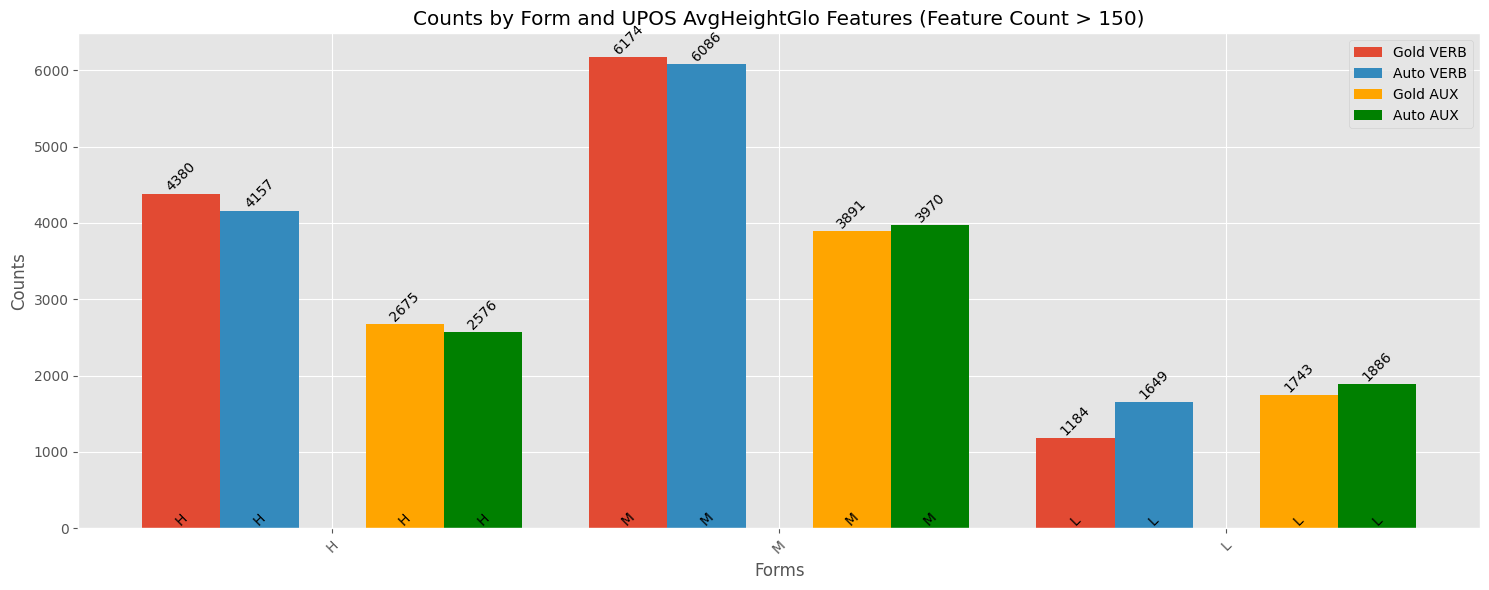

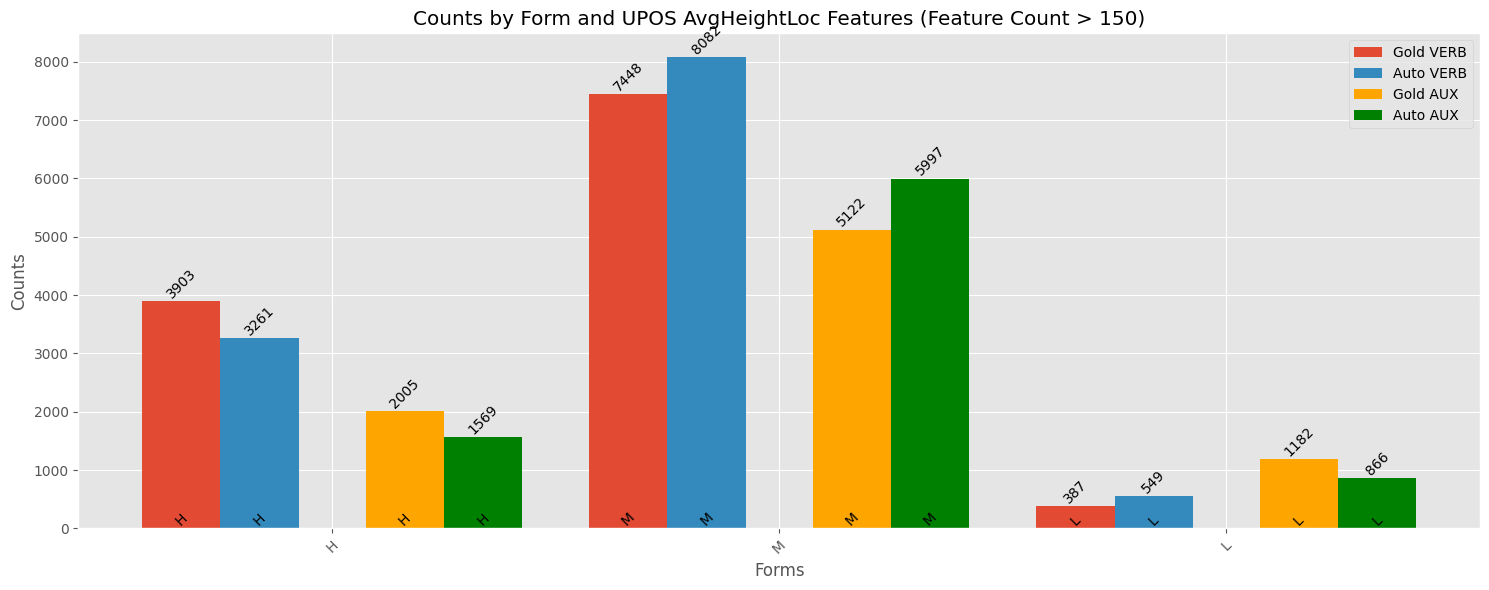

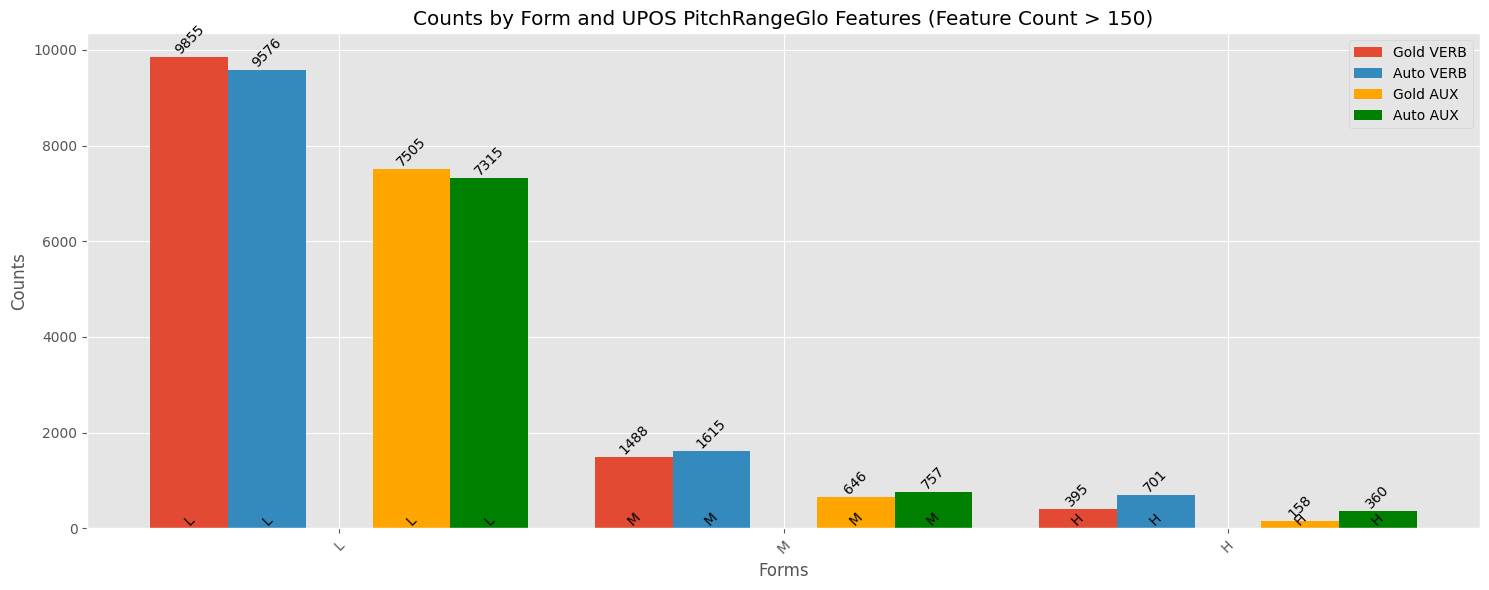

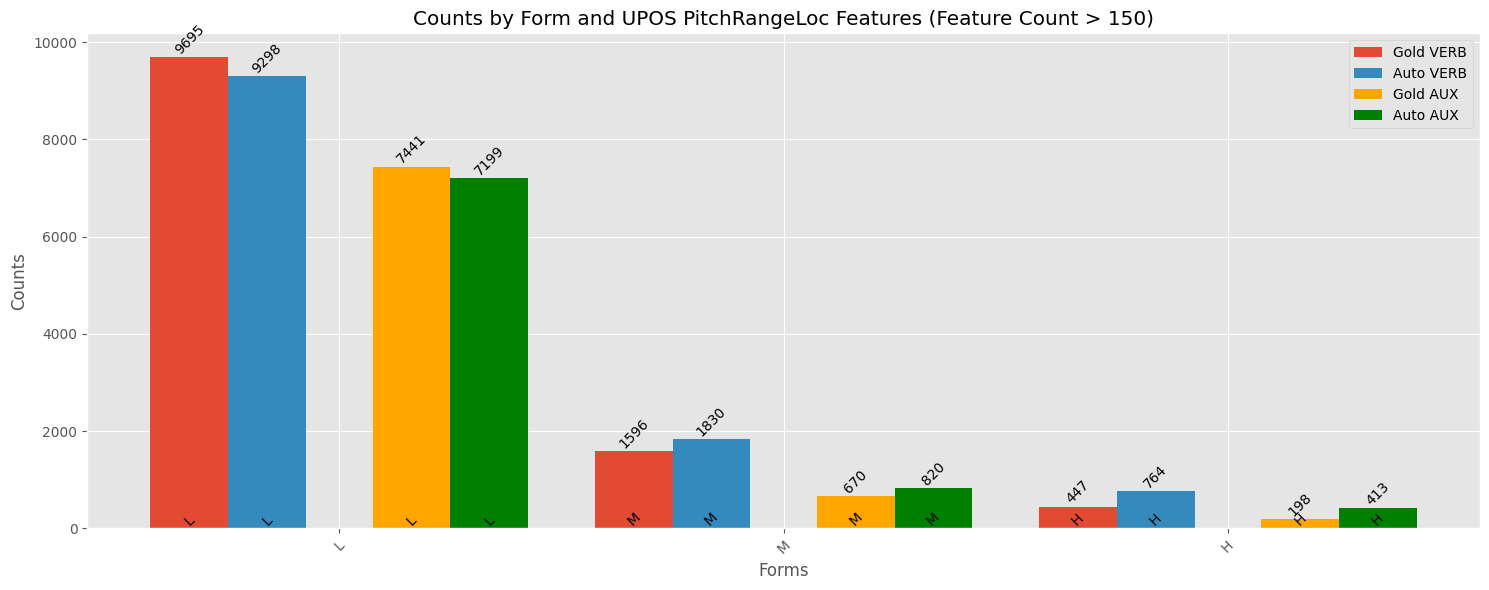

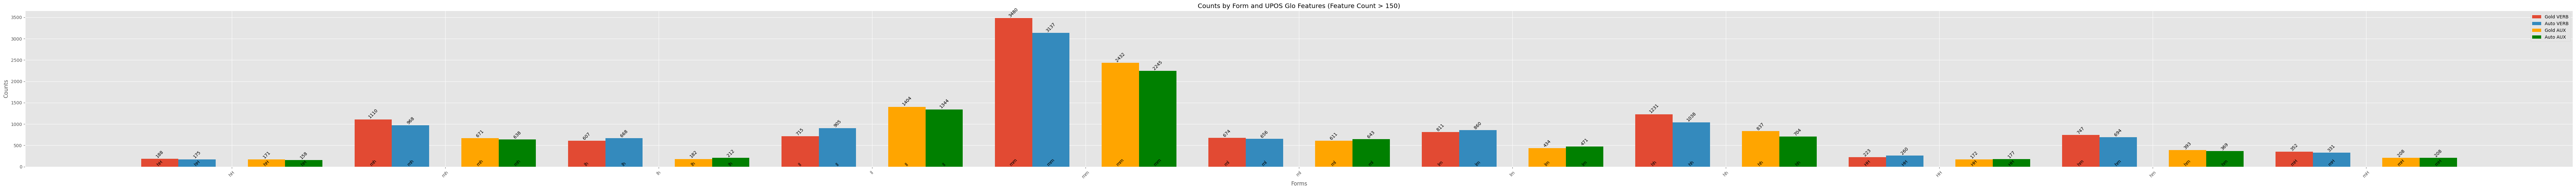

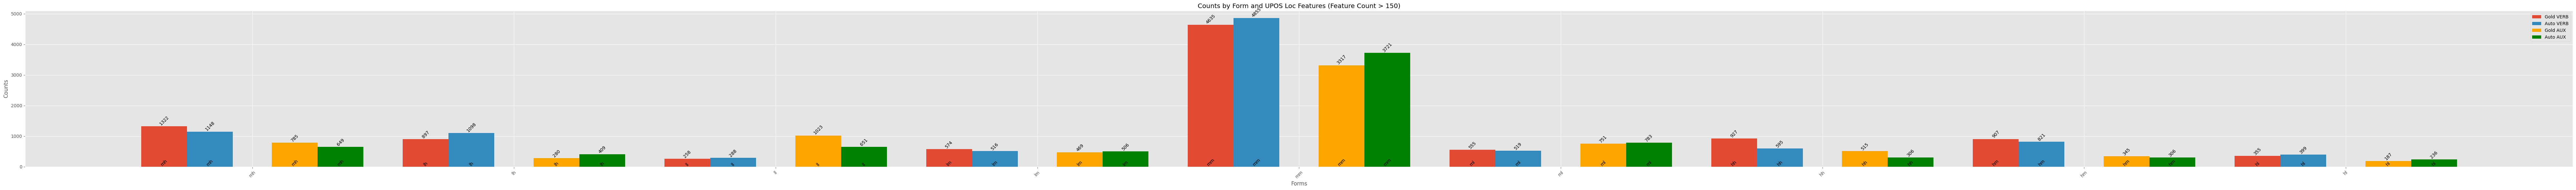

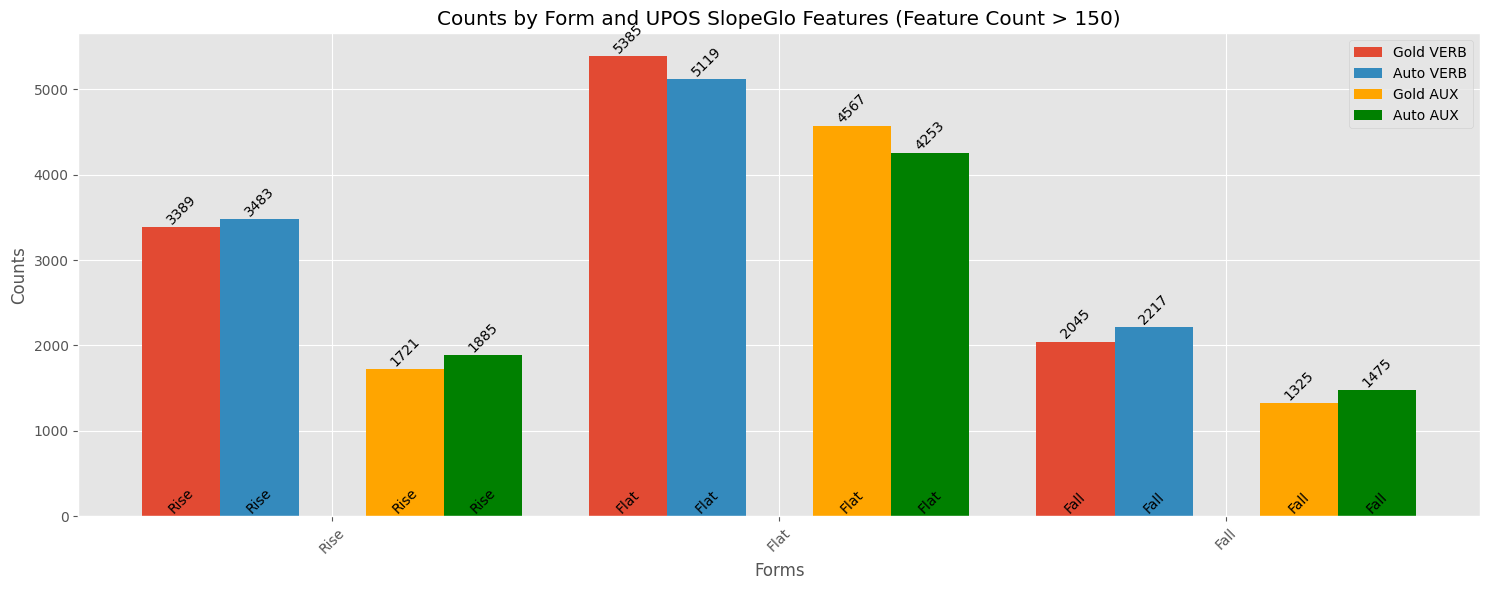

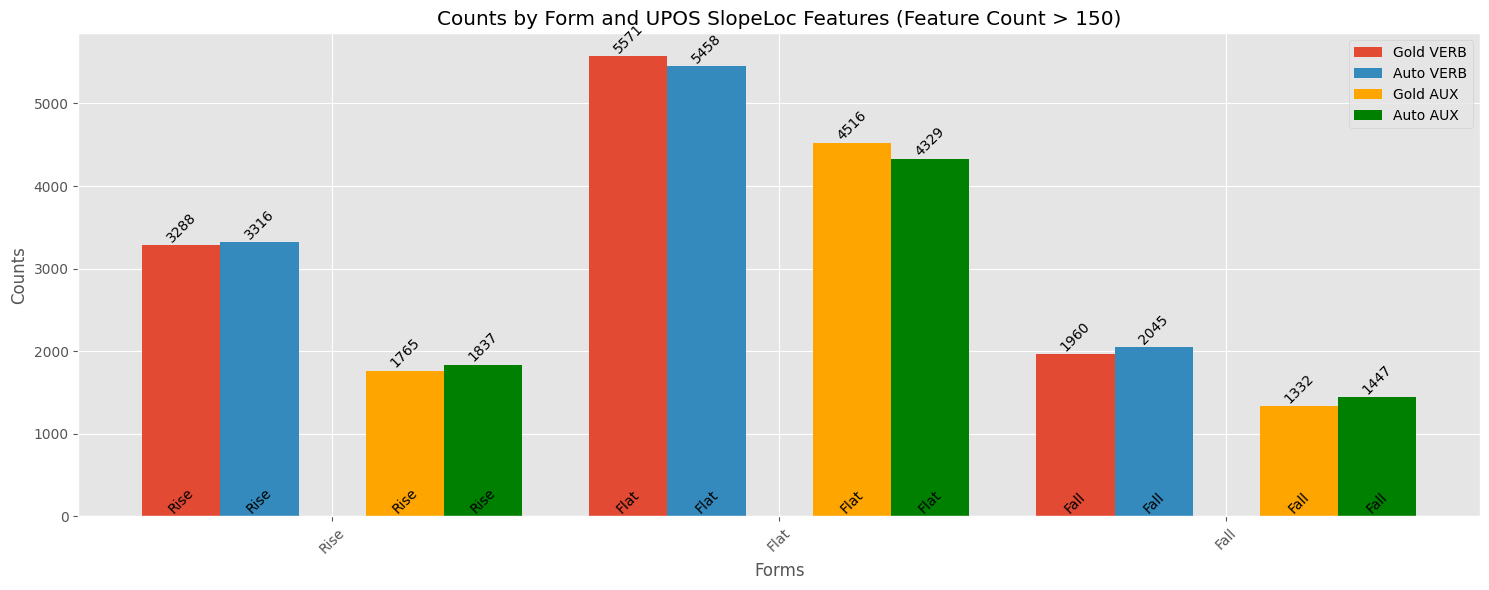

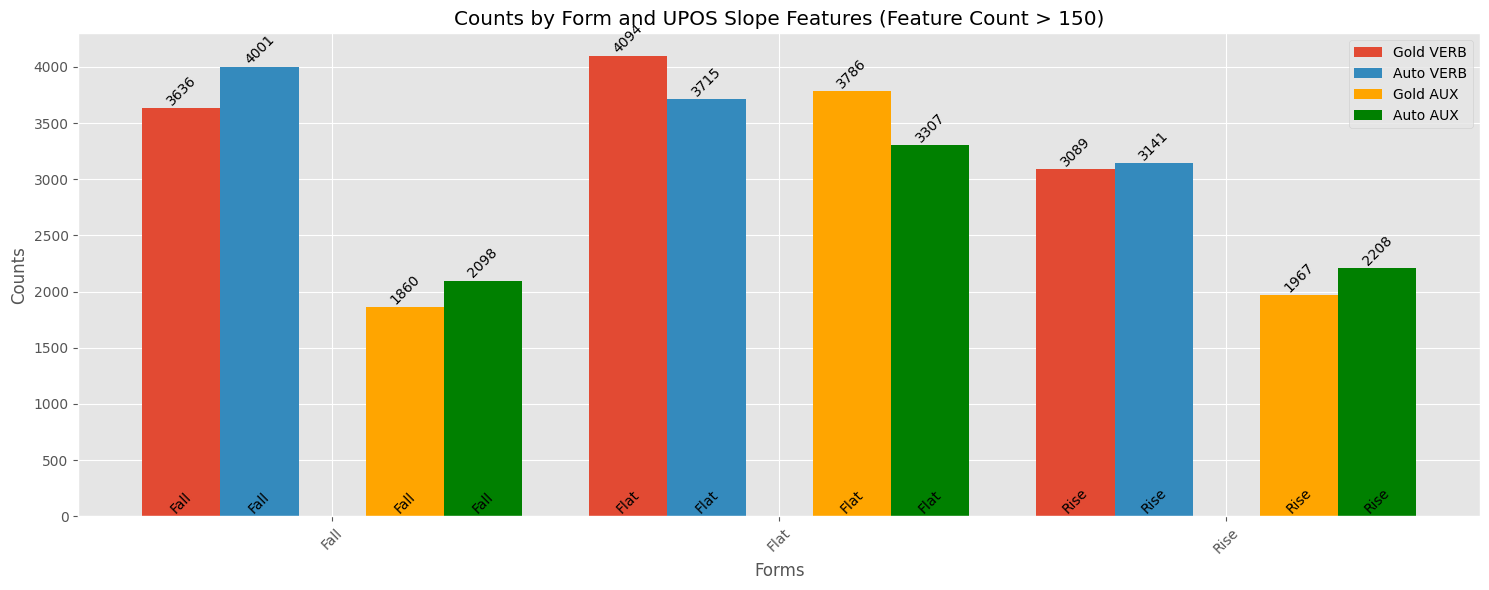

In [7]:
def global_result(gold_files:str, auto_files:str):
    """
    Function to calculate global results for SLAM and Slope features for monosyllabic verbs and auxiliaries in gold and auto sentences.

    Parameters:
    gold_files (list): List of gold files
    auto_files (list): List of auto files

    Returns:
    None
    """
    global_avgheightglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_avgheightloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_glo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_loc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slope = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    slam_v_gold = 0
    slam_v_auto = 0
    slam_a_gold = 0
    slam_a_auto = 0

    slope_v_gold = 0
    slope_v_auto = 0
    slope_a_gold = 0
    slope_a_auto = 0

    for gold_file in tqdm(gold_files):
        gold_sentences = extract_trees_and_metadata(gold_file)
        basename = os.path.basename(gold_file)
        corresponding_auto_files = [f for f in auto_files if basename in f]

        if corresponding_auto_files:
            auto_file = corresponding_auto_files[0]
            auto_sentences = extract_trees_and_metadata(auto_file)

            avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count, slam_v_gold_count, slam_v_auto_count, slam_a_gold_count, slam_a_auto_count = SLAM_mono(gold_sentences, auto_sentences)
            slopeglo_count, slopeloc_count, slope_count, slope_v_gold_count, slope_v_auto_count, slope_a_gold_count, slope_a_auto_count = Slope_mono(gold_sentences, auto_sentences)

            slam_v_gold += slam_v_gold_count
            slam_v_auto += slam_v_auto_count
            slam_a_gold += slam_a_gold_count
            slam_a_auto += slam_a_auto_count

            slope_v_gold += slope_v_gold_count
            slope_v_auto += slope_v_auto_count
            slope_a_gold += slope_a_gold_count
            slope_a_auto += slope_a_auto_count

            for upos, forms in avgheightglo_count.items():
                for form, counts in forms.items():
                    global_avgheightglo[upos][form]['Gold'] += counts['Gold']
                    global_avgheightglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in avgheightloc_count.items():
                for form, counts in forms.items():
                    global_avgheightloc[upos][form]['Gold'] += counts['Gold']
                    global_avgheightloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeglo_count.items():
                for form, counts in forms.items():
                    global_pitchrangeglo[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeloc_count.items():
                for form, counts in forms.items():
                    global_pitchrangeloc[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in glo_count.items():
                for form, counts in forms.items():
                    global_glo[upos][form]['Gold'] += counts['Gold']
                    global_glo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in loc_count.items():
                for form, counts in forms.items():
                    global_loc[upos][form]['Gold'] += counts['Gold']
                    global_loc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeglo_count.items():
                for form, counts in forms.items():
                    global_slopeglo[upos][form]['Gold'] += counts['Gold']
                    global_slopeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeloc_count.items():
                for form, counts in forms.items():
                    global_slopeloc[upos][form]['Gold'] += counts['Gold']
                    global_slopeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slope_count.items():
                for form, counts in forms.items():
                    global_slope[upos][form]['Gold'] += counts['Gold']
                    global_slope[upos][form]['Auto'] += counts['Auto']

    print(f"Total slam_v_gold: {slam_v_gold}")
    print(f"Total slam_a_gold: {slam_a_gold}")
    print(f"Total slam_v_auto: {slam_v_auto}")
    print(f"Total slam_a_auto: {slam_a_auto}")
    print(f"Total slope_v_gold: {slope_v_gold}")
    print(f"Total slope_a_gold: {slope_a_gold}")
    print(f"Total slope_v_auto: {slope_v_auto}")
    print(f"Total slope_a_auto: {slope_a_auto}")

    global_avgheightglo_df = convert_nested_dict_to_df_with_percent(global_avgheightglo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_avgheightloc_df = convert_nested_dict_to_df_with_percent(global_avgheightloc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_pitchrangeglo_df = convert_nested_dict_to_df_with_percent(global_pitchrangeglo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_pitchrangeloc_df = convert_nested_dict_to_df_with_percent(global_pitchrangeloc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_glo_df = convert_nested_dict_to_df_with_percent(global_glo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_loc_df = convert_nested_dict_to_df_with_percent(global_loc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_slopeglo_df = convert_nested_dict_to_df_with_percent(global_slopeglo, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)
    global_slopeloc_df = convert_nested_dict_to_df_with_percent(global_slopeloc, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)
    global_slope_df = convert_nested_dict_to_df_with_percent(global_slope, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)

    global_avgheightglo_df.to_csv(f'{csv_outfolder}global_avgheightglo.csv', index=False)
    global_avgheightloc_df.to_csv(f'{csv_outfolder}global_avgheightloc.csv', index=False)
    global_pitchrangeglo_df.to_csv(f'{csv_outfolder}global_pitchrangeglo.csv', index=False)
    global_pitchrangeloc_df.to_csv(f'{csv_outfolder}global_pitchrangeloc.csv', index=False)
    global_glo_df.to_csv(f'{csv_outfolder}global_glo.csv', index=False)
    global_loc_df.to_csv(f'{csv_outfolder}global_loc.csv', index=False)
    global_slopeglo_df.to_csv(f'{csv_outfolder}global_slopeglo.csv', index=False)
    global_slopeloc_df.to_csv(f'{csv_outfolder}global_slopeloc.csv', index=False)
    global_slope_df.to_csv(f'{csv_outfolder}global_slope.csv', index=False)

    global_avgheightglo_df = convert_nested_dict_to_df(global_avgheightglo)
    global_avgheightloc_df = convert_nested_dict_to_df(global_avgheightloc)
    global_pitchrangeglo_df = convert_nested_dict_to_df(global_pitchrangeglo)
    global_pitchrangeloc_df = convert_nested_dict_to_df(global_pitchrangeloc)
    global_glo_df = convert_nested_dict_to_df(global_glo)
    global_loc_df = convert_nested_dict_to_df(global_loc)
    global_slopeglo_df = convert_nested_dict_to_df(global_slopeglo)
    global_slopeloc_df = convert_nested_dict_to_df(global_slopeloc)
    global_slope_df = convert_nested_dict_to_df(global_slope)

    plot_features(global_avgheightglo_df, 'AvgHeightGlo', png_outfolder)
    plot_features(global_avgheightloc_df, 'AvgHeightLoc', png_outfolder)
    plot_features(global_pitchrangeglo_df, 'PitchRangeGlo', png_outfolder)
    plot_features(global_pitchrangeloc_df, 'PitchRangeLoc', png_outfolder)
    plot_features(global_glo_df, 'Glo', png_outfolder, 150, 80)
    plot_features(global_loc_df, 'Loc', png_outfolder, 150, 80)
    plot_features(global_slopeglo_df, 'SlopeGlo', png_outfolder)
    plot_features(global_slopeloc_df, 'SlopeLoc', png_outfolder)
    plot_features(global_slope_df, 'Slope', png_outfolder)

global_result(gold_conll_infiles, auto_conll_outfolder)


100%|██████████| 79/79 [00:00<00:00, 120.22it/s]


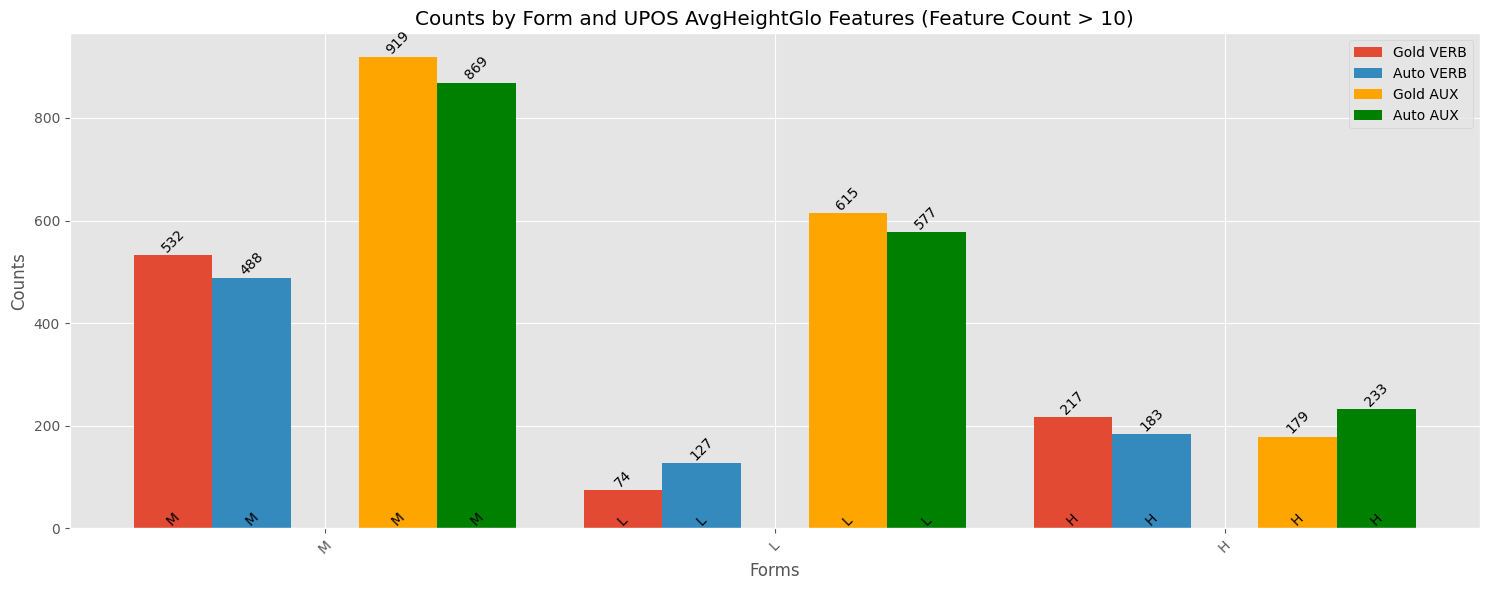

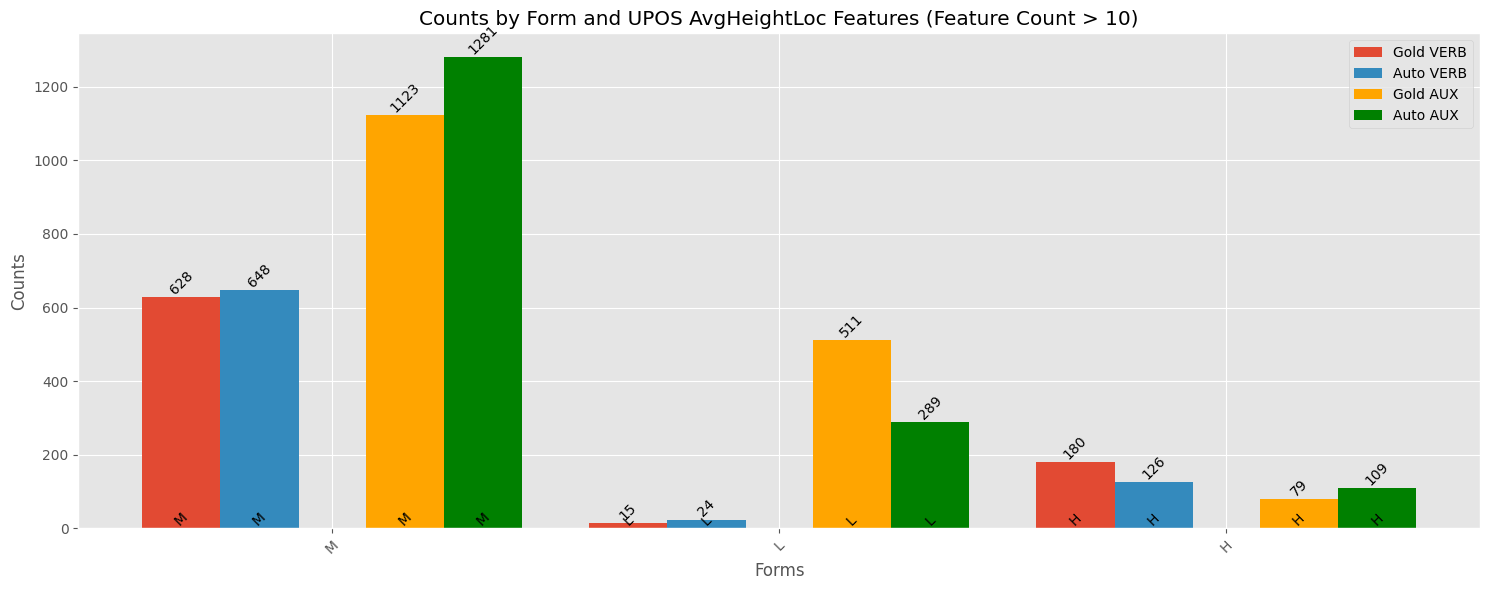

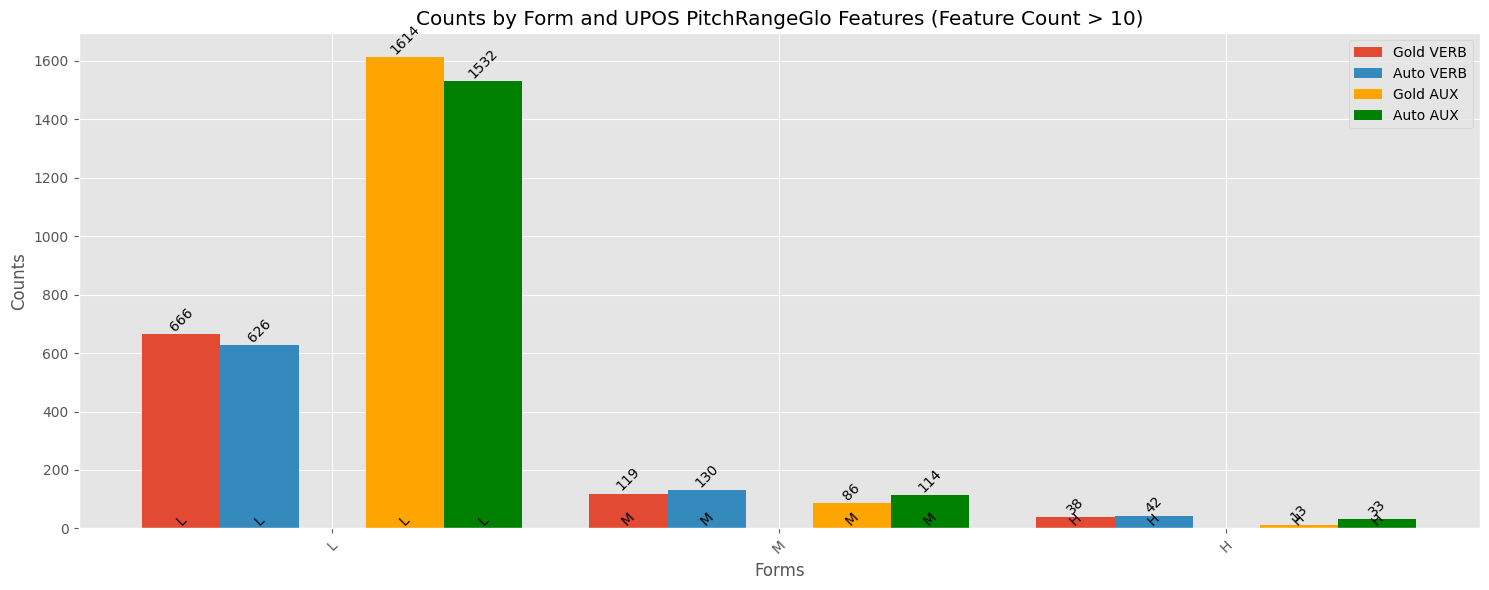

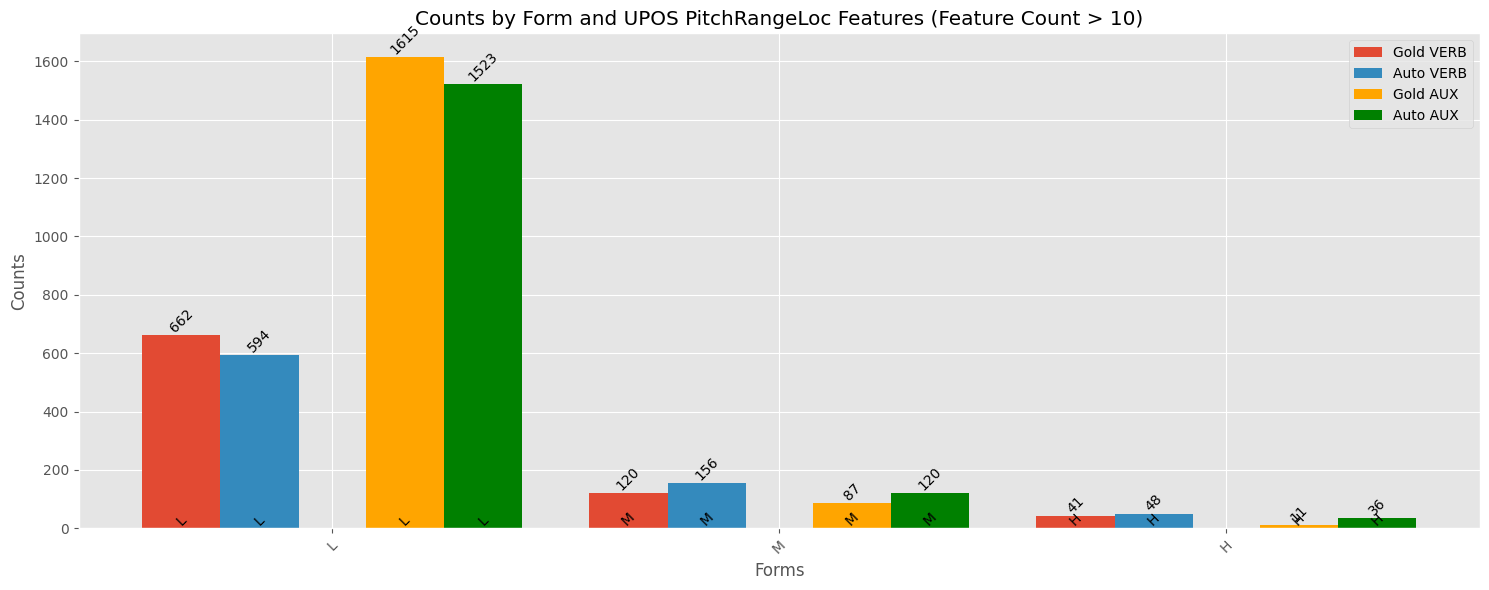

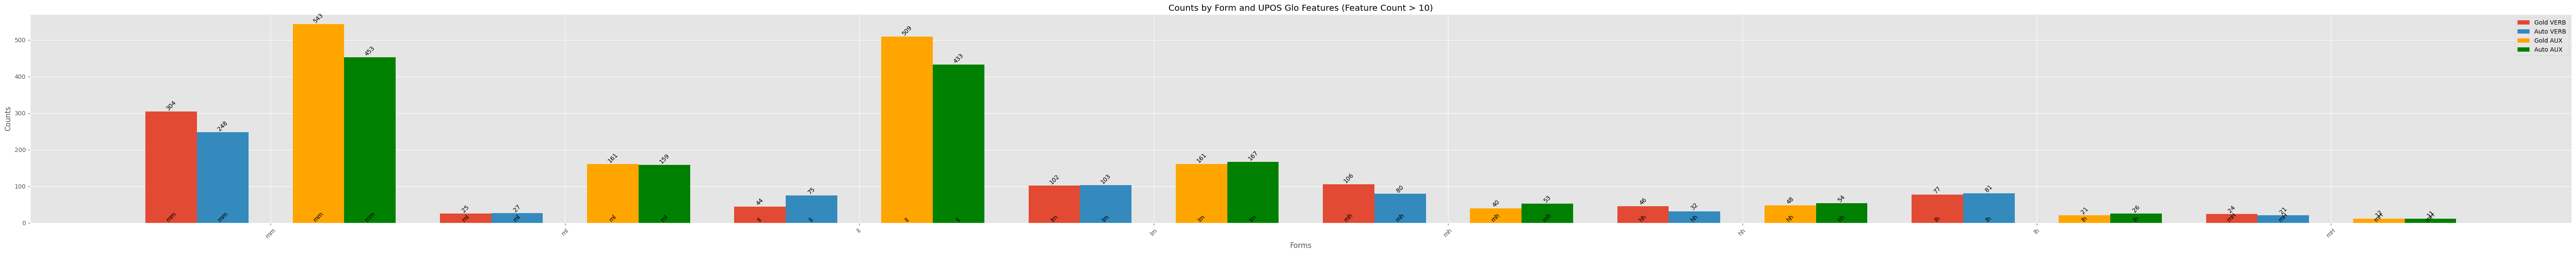

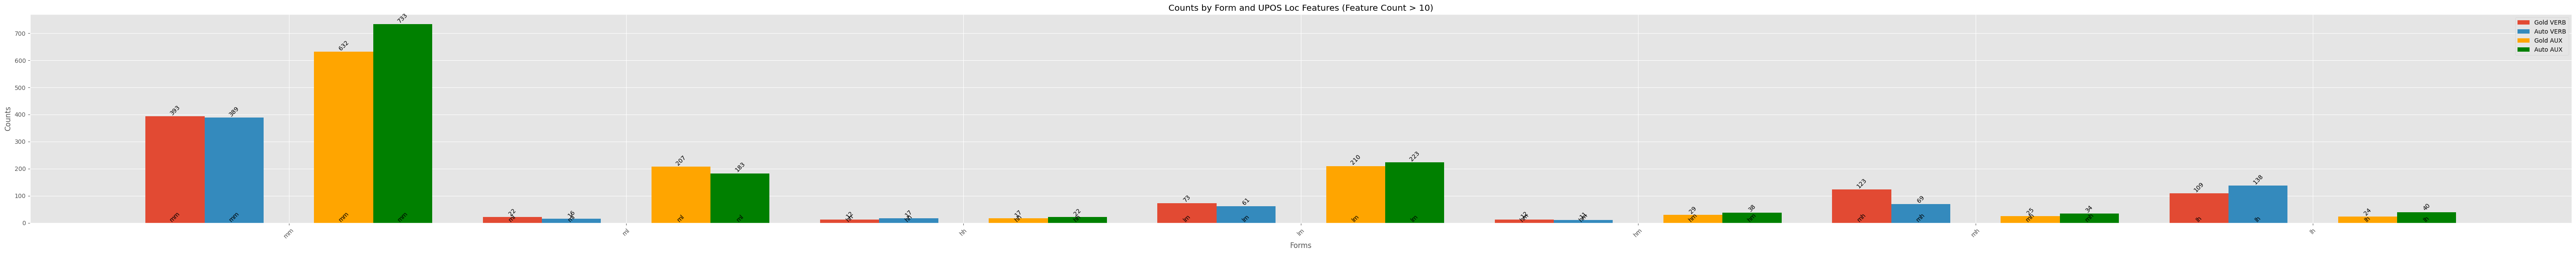

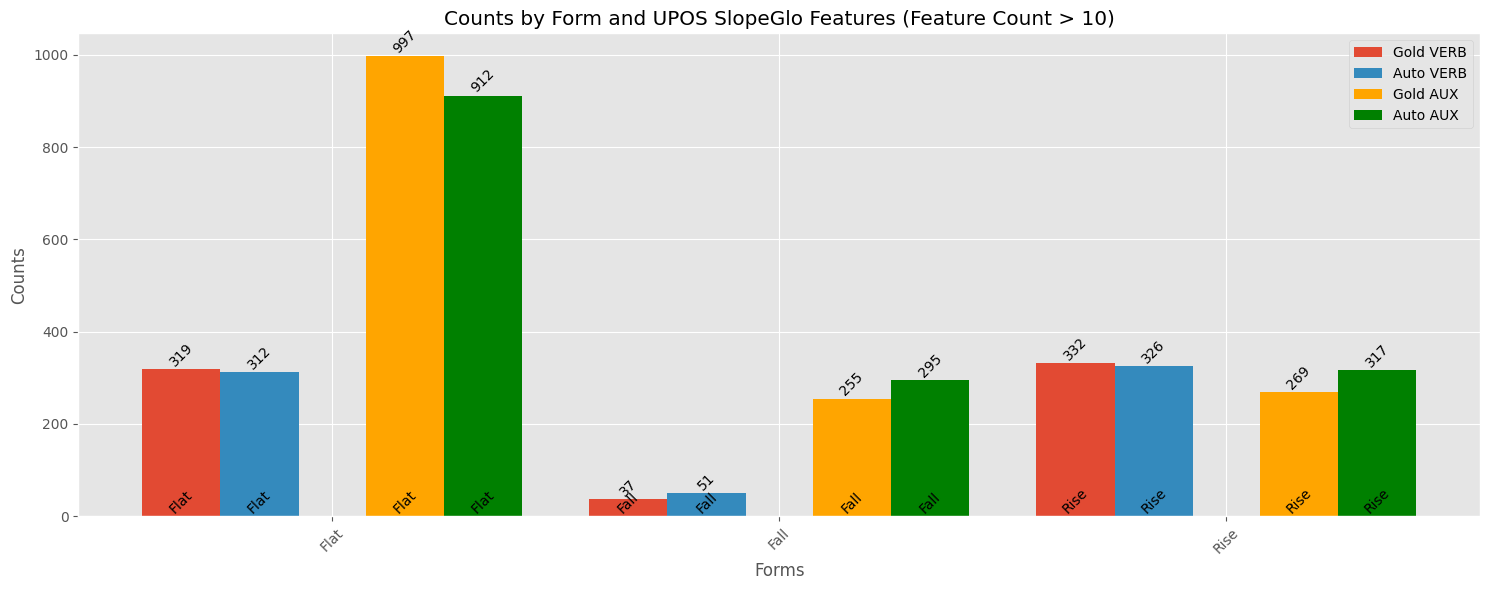

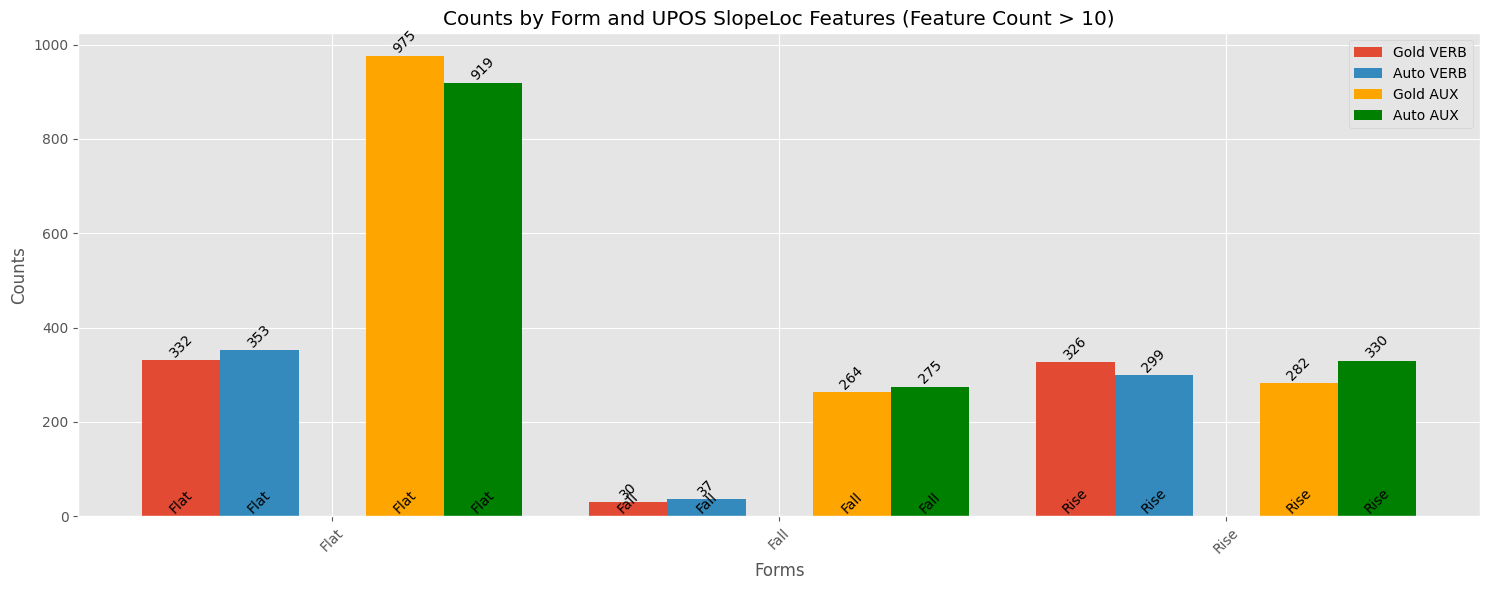

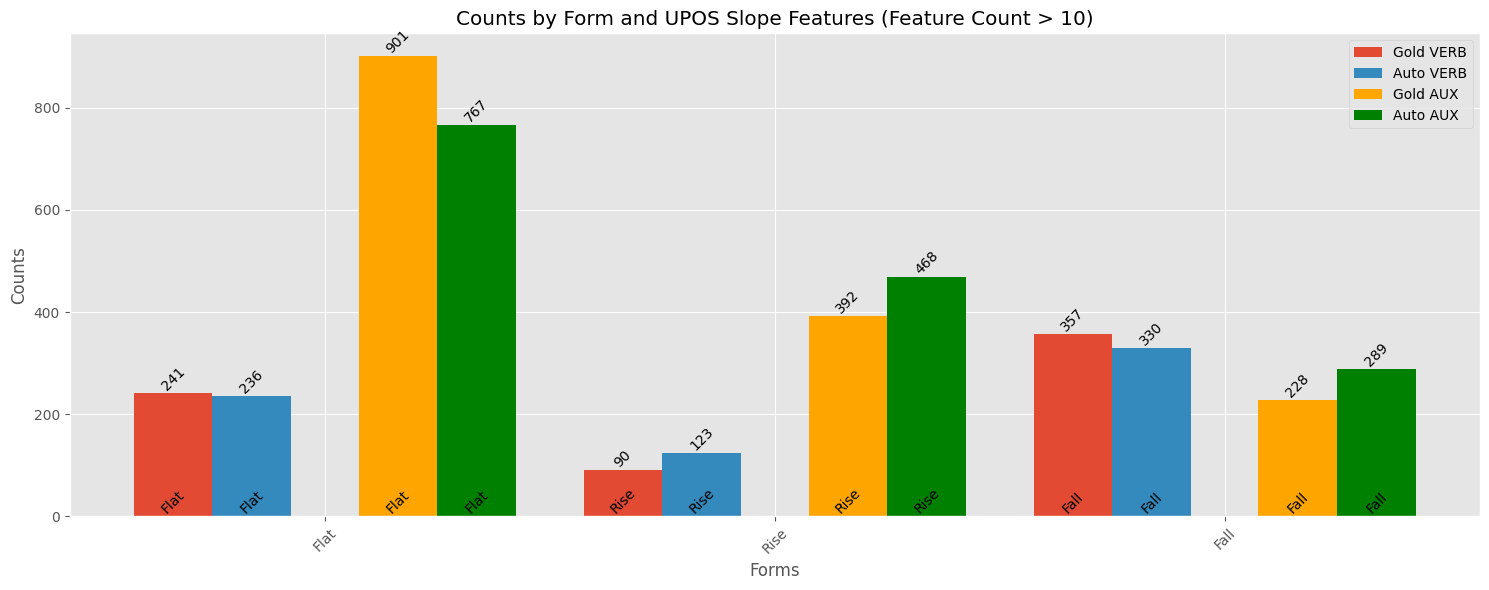

In [8]:
csv_outfolder = "CSV_mono_go/"  # Folder to save the CSV files
png_outfolder = "PNG_mono_go/"  # Folder to save the PNG files

if not os.path.exists(csv_outfolder):
    os.makedirs(csv_outfolder)

if not os.path.exists(png_outfolder):
    os.makedirs(png_outfolder)

def global_go_result(gold_files:str, auto_files:str):
    """
    Global results for SLAM and Slope features for monosyllabic "go" verbs and auxiliaries in gold and auto sentences.

    Parameters:
    gold_files (list): List of gold files
    auto_files (list): List of auto files

    Returns:
    None
    """
    global_avgheightglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_avgheightloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_glo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_loc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slope = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    
    slam_v_gold = 0
    slam_v_auto = 0
    slam_a_gold = 0
    slam_a_auto = 0

    slope_v_gold = 0
    slope_v_auto = 0
    slope_a_gold = 0
    slope_a_auto = 0
    
    for gold_file in tqdm(gold_files):
        gold_sentences = extract_trees_and_metadata(gold_file)
        basename = os.path.basename(gold_file)
        corresponding_auto_files = [f for f in auto_files if basename in f]

        if corresponding_auto_files:
            auto_file = corresponding_auto_files[0]
            auto_sentences = extract_trees_and_metadata(auto_file)

            avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count, slam_v_gold_count, slam_v_auto_gold, slam_a_gold_count, slam_a_auto_count = SLAM_mono(gold_sentences, auto_sentences, token_form='go')
            slopeglo_count, slopeloc_count, slope_count, slope_v_gold_count, slope_v_auto_count, slope_a_gold_count, slope_a_auto_count = Slope_mono(gold_sentences, auto_sentences, token_form='go')


            for upos, forms in avgheightglo_count.items():
                for form, counts in forms.items():
                    global_avgheightglo[upos][form]['Gold'] += counts['Gold']
                    global_avgheightglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in avgheightloc_count.items():
                for form, counts in forms.items():
                    global_avgheightloc[upos][form]['Gold'] += counts['Gold']
                    global_avgheightloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeglo_count.items():
                for form, counts in forms.items():
                    global_pitchrangeglo[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeloc_count.items():
                for form, counts in forms.items():
                    global_pitchrangeloc[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in glo_count.items():
                for form, counts in forms.items():
                    global_glo[upos][form]['Gold'] += counts['Gold']
                    global_glo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in loc_count.items():
                for form, counts in forms.items():
                    global_loc[upos][form]['Gold'] += counts['Gold']
                    global_loc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeglo_count.items():
                for form, counts in forms.items():
                    global_slopeglo[upos][form]['Gold'] += counts['Gold']
                    global_slopeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeloc_count.items():
                for form, counts in forms.items():
                    global_slopeloc[upos][form]['Gold'] += counts['Gold']
                    global_slopeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slope_count.items():
                for form, counts in forms.items():
                    global_slope[upos][form]['Gold'] += counts['Gold']
                    global_slope[upos][form]['Auto'] += counts['Auto']
            
            slam_v_gold += slam_v_gold_count
            slam_v_auto += slam_v_auto_gold
            slam_a_gold += slam_a_gold_count
            slam_a_auto += slam_a_auto_count

            slope_v_gold += slope_v_gold_count
            slope_v_auto += slope_v_auto_count
            slope_a_gold += slope_a_gold_count
            slope_a_auto += slope_a_auto_count

    
            
    global_avgheightglo_df = convert_nested_dict_to_df_with_percent(global_avgheightglo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_avgheightloc_df = convert_nested_dict_to_df_with_percent(global_avgheightloc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_pitchrangeglo_df = convert_nested_dict_to_df_with_percent(global_pitchrangeglo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_pitchrangeloc_df = convert_nested_dict_to_df_with_percent(global_pitchrangeloc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_glo_df = convert_nested_dict_to_df_with_percent(global_glo, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_loc_df = convert_nested_dict_to_df_with_percent(global_loc, slam_v_gold, slam_v_auto, slam_a_gold, slam_a_auto)
    global_slopeglo_df = convert_nested_dict_to_df_with_percent(global_slopeglo, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)
    global_slopeloc_df = convert_nested_dict_to_df_with_percent(global_slopeloc, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)
    global_slope_df = convert_nested_dict_to_df_with_percent(global_slope, slope_v_gold, slope_v_auto, slope_a_gold, slope_a_auto)


    global_avgheightglo_df.to_csv(f'{csv_outfolder}global_avgheightglo_go.csv', index=False)
    global_avgheightloc_df.to_csv(f'{csv_outfolder}global_avgheightloc_go.csv', index=False)
    global_pitchrangeglo_df.to_csv(f'{csv_outfolder}global_pitchrangeglo_go.csv', index=False)
    global_pitchrangeloc_df.to_csv(f'{csv_outfolder}global_pitchrangeloc_go.csv', index=False)
    global_glo_df.to_csv(f'{csv_outfolder}global_glo_go.csv', index=False)
    global_loc_df.to_csv(f'{csv_outfolder}global_loc_go.csv', index=False)
    global_slopeglo_df.to_csv(f'{csv_outfolder}global_slopeglo_go.csv', index=False)
    global_slopeloc_df.to_csv(f'{csv_outfolder}global_slopeloc_go.csv', index=False)
    global_slope_df.to_csv(f'{csv_outfolder}global_slope_go.csv', index=False)

    global_avgheightglo_df = convert_nested_dict_to_df(global_avgheightglo)
    global_avgheightloc_df = convert_nested_dict_to_df(global_avgheightloc)
    global_pitchrangeglo_df = convert_nested_dict_to_df(global_pitchrangeglo)
    global_pitchrangeloc_df = convert_nested_dict_to_df(global_pitchrangeloc)
    global_glo_df = convert_nested_dict_to_df(global_glo)
    global_loc_df = convert_nested_dict_to_df(global_loc)
    global_slopeglo_df = convert_nested_dict_to_df(global_slopeglo)
    global_slopeloc_df = convert_nested_dict_to_df(global_slopeloc)
    global_slope_df = convert_nested_dict_to_df(global_slope)
    
    plot_features(global_avgheightglo_df, 'AvgHeightGlo', png_outfolder, 10)
    plot_features(global_avgheightloc_df, 'AvgHeightLoc', png_outfolder, 10)
    plot_features(global_pitchrangeglo_df, 'PitchRangeGlo', png_outfolder, 10)
    plot_features(global_pitchrangeloc_df, 'PitchRangeLoc', png_outfolder, 10)
    plot_features(global_glo_df, 'Glo', png_outfolder, 10, 60)
    plot_features(global_loc_df, 'Loc', png_outfolder, 10, 60)
    plot_features(global_slopeglo_df, 'SlopeGlo', png_outfolder, 10)
    plot_features(global_slopeloc_df, 'SlopeLoc', png_outfolder, 10)
    plot_features(global_slope_df, 'Slope', png_outfolder, 10)

global_go_result(gold_conll_infiles, auto_conll_outfolder)

In [9]:
def aux_mono_slam(gold_sentences:str , auto_sentences:str ) -> tuple:
    """
    Retrieves the SLAM features for monosyllabic auxiliaries in gold and auto sentences.

    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences

    Returns:
    avgheightglo_count (defaultdict): Counts for AvgHeightGlo feature
    avgheightloc_count (defaultdict): Counts for AvgHeightLoc feature
    pitchrangeglo_count (defaultdict): Counts for PitchRangeGlo feature
    pitchrangeloc_count (defaultdict): Counts for PitchRangeLoc feature
    glo_count (defaultdict): Counts for Glo feature
    loc_count (defaultdict): Counts for Loc feature
    """
    avgheightglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    avgheightloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    glo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    loc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))


    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        g_sent = ' '.join([token['t'].lower() for token in gold_sentence])
        a_sent = ' '.join([token['t'].lower() for token in auto_sentence])
        if g_sent == a_sent:
            for gold_token, auto_token in zip(gold_sentence, auto_sentence):
                if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag'] and (gold_token['tag'] == 'AUX' and auto_token['tag'] == 'AUX'):
                    gold_misc_features = gold_token.get('misc', '')
                    auto_misc_features = auto_token.get('misc', '')

                    if gold_misc_features and auto_misc_features:
                        gold_feature_dico = build_feature_dico(gold_misc_features)
                        auto_feature_dico = build_feature_dico(auto_misc_features)


                        gold_token_lower = gold_token['t'].lower()
                        auto_token_lower = auto_token['t'].lower()

                        if "'" in gold_token['t'] or "'" in auto_token['t']:
                            continue
                        
                        etiquettes = ['Syl1AvgHeightGlo', 'Syl1AvgHeightLoc', 'Syl1PitchRangeGlo', 'Syl1PitchRangeLoc', 'Syl1Glo', 'Syl1Loc']
                        if any(e in gold_feature_dico for e in etiquettes) and any(e in auto_feature_dico for e in etiquettes):
                            if gold_token['t'] == auto_token['t']:
                                # GOLD
                                if gold_feature_dico.get('SyllableCount') == '1':
                                    for key, value in gold_feature_dico.items():
                                        avgheightglo = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightGlo')]
                                        for height in avgheightglo:
                                            avgheightglo_count[gold_token_lower][height]['Gold'] += 1
                                        
                                        avgheightloc = [value for key, value in gold_feature_dico.items() if key.endswith('AvgHeightLoc')]
                                        for height in avgheightloc:
                                            avgheightloc_count[gold_token_lower][height]['Gold'] += 1
                                        
                                        pitchrangeglo = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeGlo')]
                                        for pitch in pitchrangeglo:
                                            pitchrangeglo_count[gold_token_lower][pitch]['Gold'] += 1

                                        pitchrangeloc = [value for key, value in gold_feature_dico.items() if key.endswith('PitchRangeLoc')]
                                        for pitch in pitchrangeloc:
                                            pitchrangeloc_count[gold_token_lower][pitch]['Gold'] += 1

                                        glo = [value for key, value in gold_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        for value in glo:
                                            glo_count[gold_token_lower][value]['Gold'] += 1

                                        loc = [value for key, value in gold_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        for value in loc:
                                            loc_count[gold_token_lower][value]['Gold'] += 1

                                # AUTO
                                if auto_feature_dico.get('SyllableCount') == '1':
                                    for key, value in auto_feature_dico.items():
                                        avgheightglo = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightGlo')]
                                        for height in avgheightglo:
                                            avgheightglo_count[auto_token_lower][height]['Auto'] += 1
                                        
                                        avgheightloc = [value for key, value in auto_feature_dico.items() if key.endswith('AvgHeightLoc')]
                                        for height in avgheightloc:
                                            avgheightloc_count[auto_token_lower][height]['Auto'] += 1
                                        
                                        pitchrangeglo = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeGlo')]
                                        for pitch in pitchrangeglo:
                                            pitchrangeglo_count[auto_token_lower][pitch]['Auto'] += 1

                                        pitchrangeloc = [value for key, value in auto_feature_dico.items() if key.endswith('PitchRangeLoc')]
                                        for pitch in pitchrangeloc:
                                            pitchrangeloc_count[auto_token_lower][pitch]['Auto'] += 1

                                        glo = [value for key, value in auto_feature_dico.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        for value in glo:
                                            glo_count[auto_token_lower][value]['Auto'] += 1
                                        
                                        loc = [value for key, value in auto_feature_dico.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        for value in loc:
                                            loc_count[auto_token_lower][value]['Auto'] += 1
    

    return avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count

In [10]:
def aux_mono_slope(gold_sentences:str , auto_sentences:str ) -> tuple:
    """
    Retrieves the Slope features for monosyllabic auxiliaries in gold and auto sentences.

    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences

    Returns:
    slopeglo_count (defaultdict): Counts for SlopeGlo feature
    slopeloc_count (defaultdict): Counts for SlopeLoc feature
    slope_count (defaultdict): Counts for Slope feature
    """
    slopeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slopeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slope_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        g_sent = ' '.join([token['t'].lower() for token in gold_sentence])
        a_sent = ' '.join([token['t'].lower() for token in auto_sentence])
        if g_sent == a_sent:
            for gold_token, auto_token in zip(gold_sentence, auto_sentence):
                if 'PUNCT' not in gold_token['tag'] and 'PUNCT' not in auto_token['tag'] and (gold_token['tag'] == 'AUX' and auto_token['tag'] == 'AUX'):
                    gold_misc_features = gold_token.get('misc', '')
                    auto_misc_features = auto_token.get('misc', '')

                    if gold_misc_features and auto_misc_features:
                        gold_feature_dico = build_feature_dico(gold_misc_features)
                        auto_feature_dico = build_feature_dico(auto_misc_features)

                        gold_token_lower = gold_token['t'].lower()
                        auto_token_lower = auto_token['t'].lower()

                        if "'" in gold_token['t'] or "'" in auto_token['t']:
                            continue
                        
                        etiquettes = ['Syl1SlopeGlo', 'Syl1SlopeLoc', 'Syl1Slope']
                        if all(e in gold_feature_dico for e in etiquettes) and all(e in auto_feature_dico for e in etiquettes):
                            if gold_token['t'] == auto_token['t']:
                                # GOLD
                                if gold_feature_dico.get('SyllableCount') == '1':
                                    slopeglo = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[gold_token_lower][slope]['Gold'] += 1

                                    slopeloc = [value for key, value in gold_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[gold_token_lower][slope]['Gold'] += 1

                                    slope = [value for key, value in gold_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[gold_token_lower][value]['Gold'] += 1

                                # AUTO
                                if auto_feature_dico.get('SyllableCount') == '1':
                                    slopeglo = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeGlo')]
                                    for slope in slopeglo:
                                        slopeglo_count[auto_token_lower][slope]['Auto'] += 1

                                    slopeloc = [value for key, value in auto_feature_dico.items() if key.endswith('SlopeLoc')]
                                    for slope in slopeloc:
                                        slopeloc_count[auto_token_lower][slope]['Auto'] += 1

                                    slope = [value for key, value in auto_feature_dico.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                    for value in slope:
                                        slope_count[auto_token_lower][value]['Auto'] += 1

    

    return slopeglo_count, slopeloc_count, slope_count

100%|██████████| 79/79 [00:04<00:00, 16.26it/s]


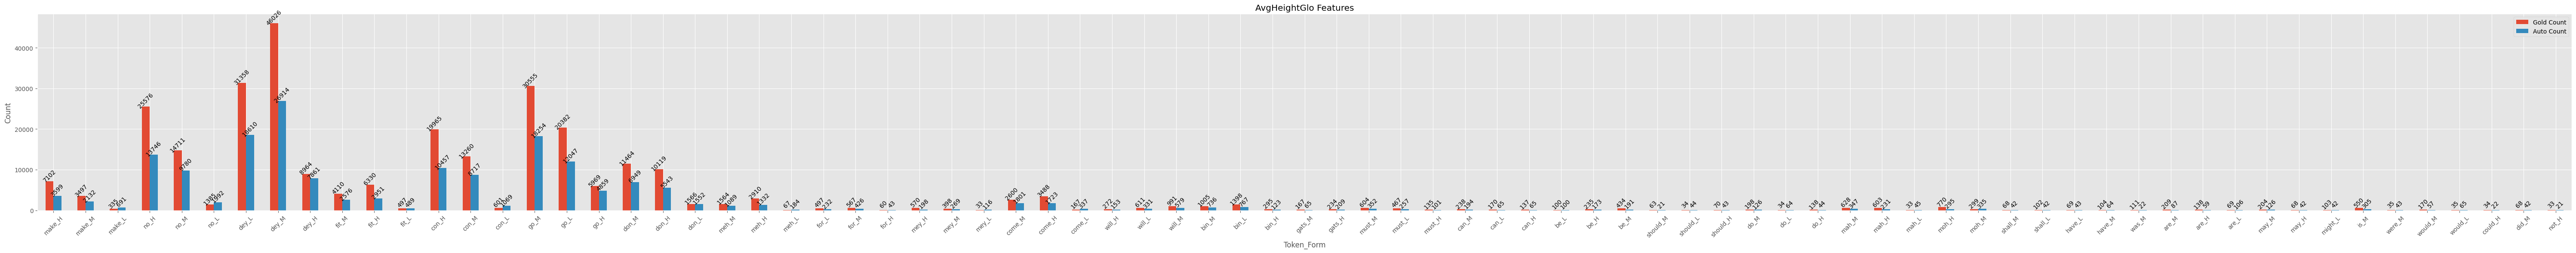

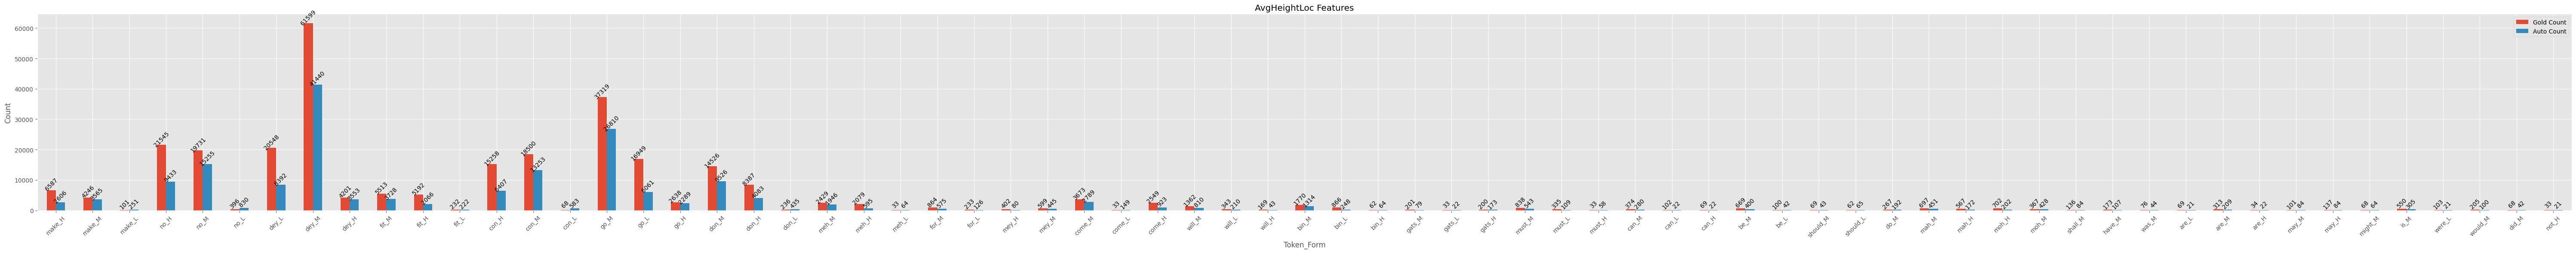

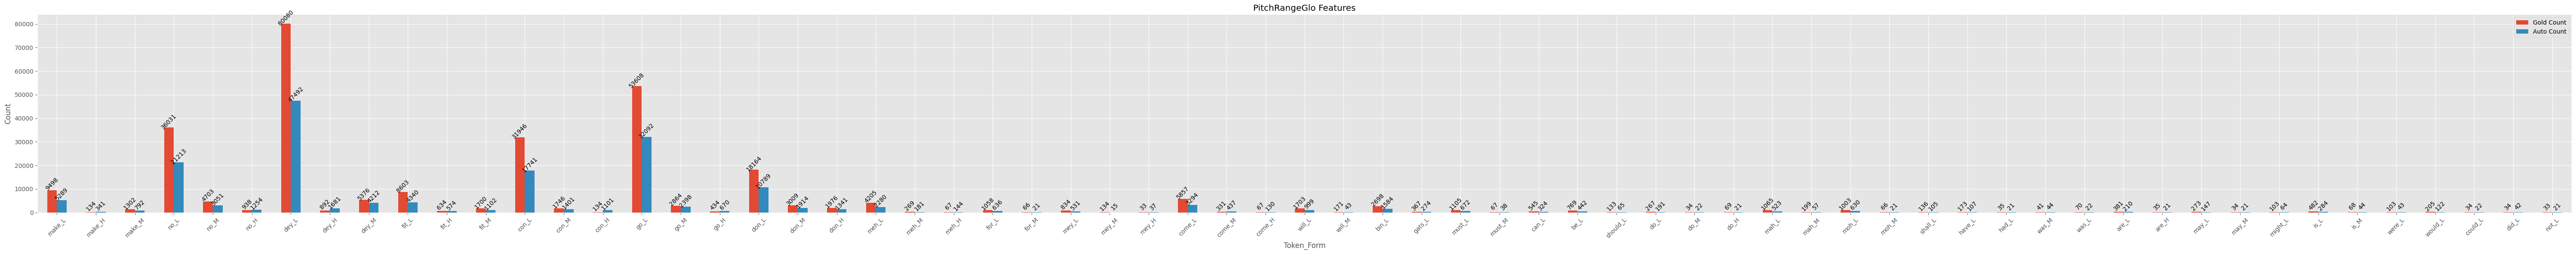

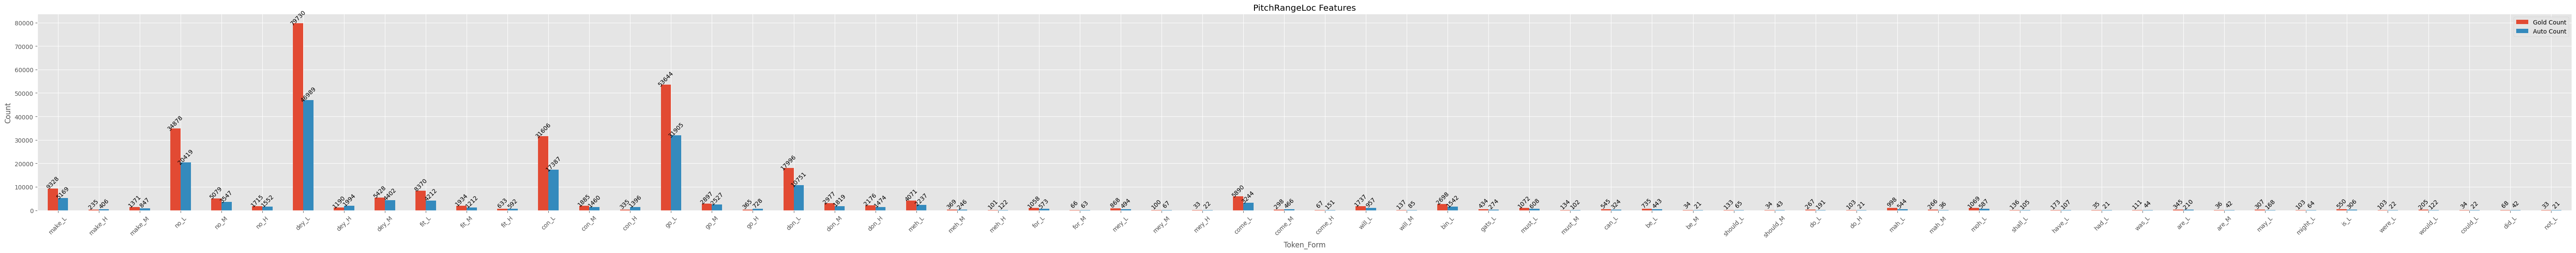

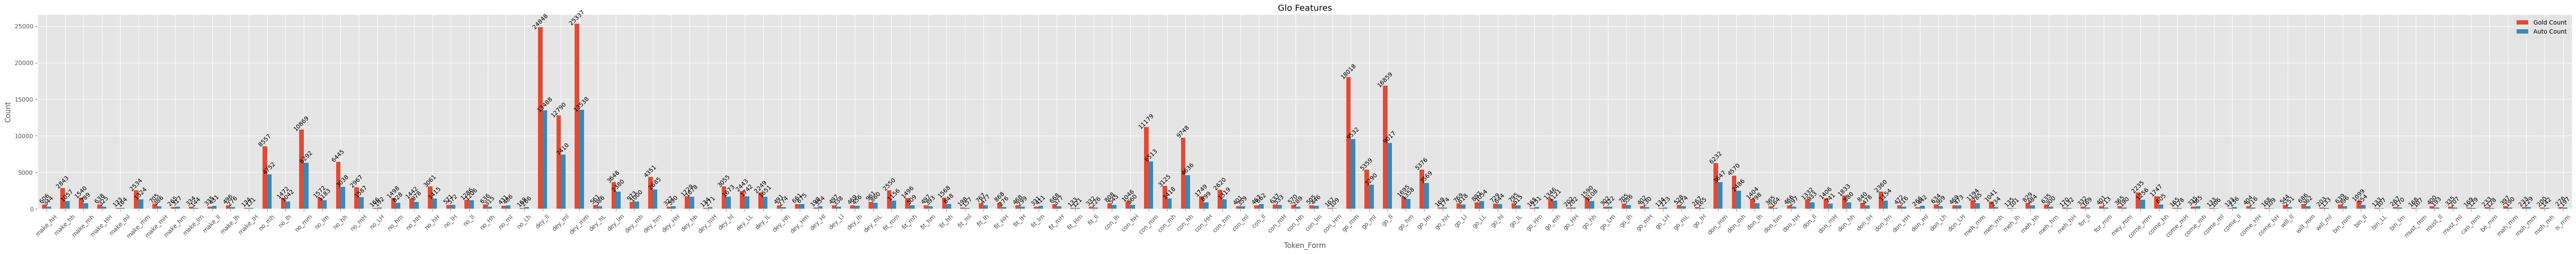

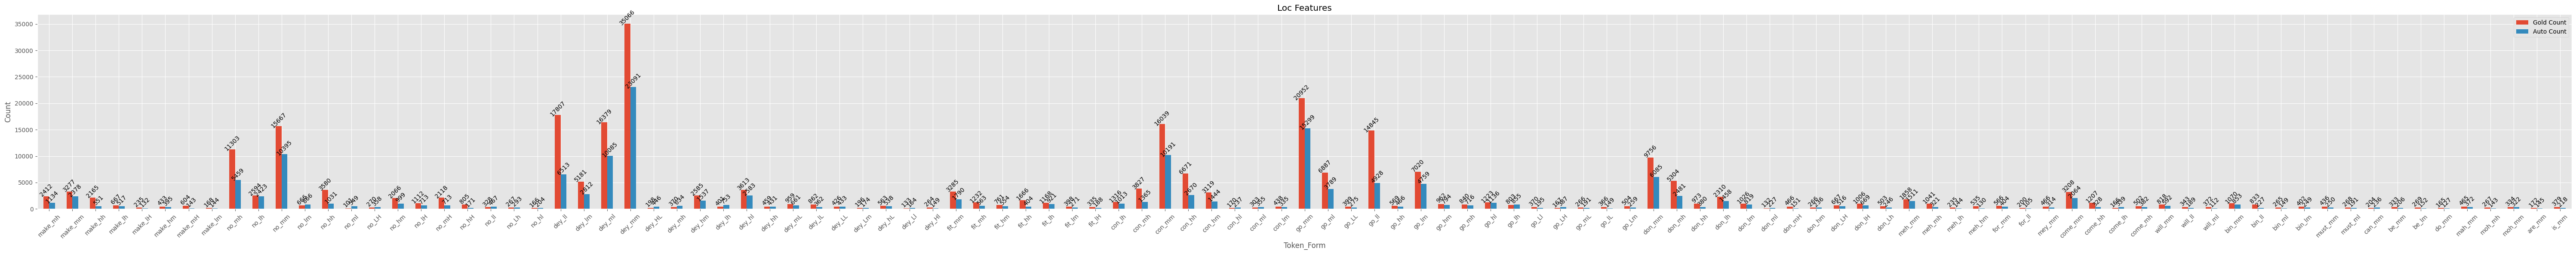

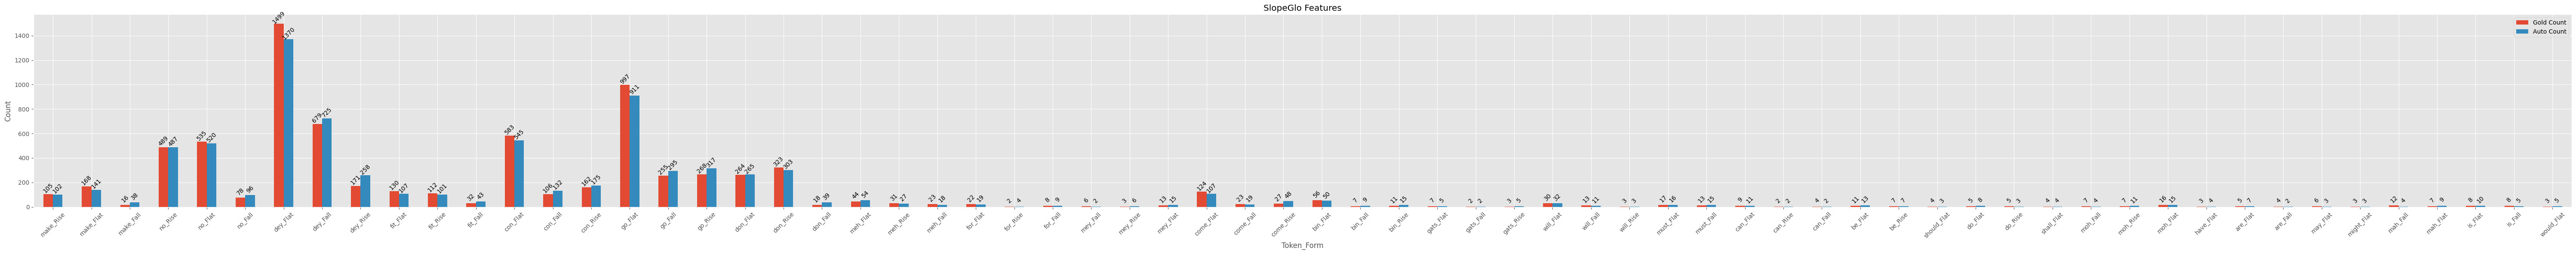

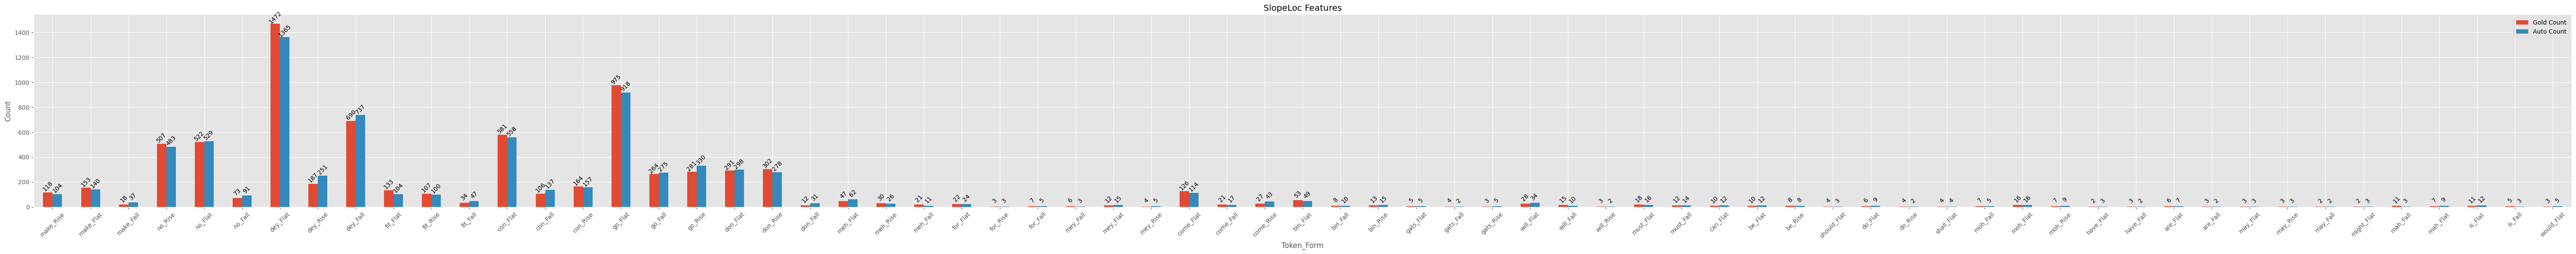

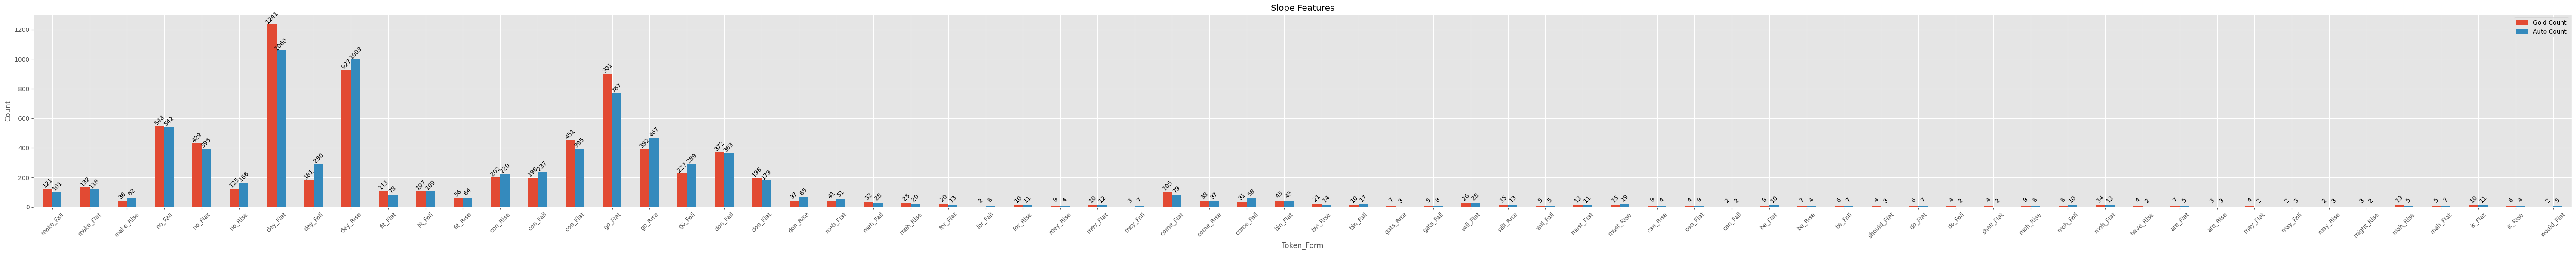

In [11]:
def convert_mono_defaultdict_to_df(nested_dict: defaultdict) -> pd.DataFrame:
    """
    Converts a nested defaultdict to a DataFrame.

    Parameters:
    nested_dict (defaultdict): Nested defaultdict to be converted

    Returns:
    df (DataFrame): DataFrame
    """
    data = []
    for token, forms in nested_dict.items():
        for form, counts in forms.items():
            data.append({
                'Token': token,
                'Form': form,
                'Gold Count': counts['Gold'],
                'Auto Count': counts['Auto']
            })
    return pd.DataFrame(data)

def convert_mono_defaultdict_to_df_with_percent(nested_dict:defaultdict , total_count: tuple) -> pd.DataFrame:
    """
    Converts a nested defaultdict to a DataFrame with the percentage of the total count.

    Parameters:
    nested_dict (defaultdict): Nested defaultdict to be converted
    total_count (tuple): Total count of gold and auto sentences

    Returns:
    df (DataFrame): DataFrame
    """
    data = []
    total_gold, total_auto = total_count

    for token, forms in nested_dict.items():
        for form, counts in forms.items():
            # Format des valeurs en une chaîne avec le pourcentage après le compte
            gold_with_percent = f"{counts['Gold']} ({(counts['Gold'] / total_gold * 100):.2f}%)"
            auto_with_percent = f"{counts['Auto']} ({(counts['Auto'] / total_auto * 100):.2f}%)"
            
            # Ajout des données formatées dans la liste
            data.append({
                'Token': token,
                'Form': form,
                'Gold Count (Percent)': gold_with_percent,  # Combiner compte et pourcentage dans une seule colonne
                'Auto Count (Percent)': auto_with_percent   # Combiner compte et pourcentage dans une seule colonne
            })

    # Création d'un DataFrame à partir de la liste des données
    return pd.DataFrame(data)

# def plot_token(df, feature_name, png_outfolder, x_length=15):
#     tokens = df['Token'].unique()
#     for token in tokens:
#         token_df = df[df['Token'] == token].copy()
#         token_df.loc[:, 'Token_Form'] = token_df['Token'] + '_' + token_df['Form']
#         ax = token_df.plot(kind='bar', x='Token_Form', y=['Gold Count', 'Auto Count'], figsize=(x_length, 6))
#         plt.title(f'{feature_name} Features for {token}')
#         plt.ylabel('Count')
#         plt.legend(loc='best')
#         plt.xticks(rotation=45)
#         plt.tight_layout()

#         for p in ax.patches:
#             ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                         ha='center', va='center', rotation=45, xytext=(0, 10),
#                         textcoords='offset points')

#         plt.savefig(f'{png_outfolder}{feature_name}_{token}_features.png')
#         plt.show()

def plot_token(df:pd.DataFrame, feature_name:str, png_outfolder:str , x_length:int=15, limite:int=1) -> None:
    """
    Plots the features for each token. The plot is saved as a PNG file.

    Parameters:
    df (DataFrame): DataFrame
    feature_name (str): Name of the feature
    png_outfolder (str): Folder to save the PNG files
    x_length (int): Length of the x-axis
    limite (int): Limit to filter the features

    Returns:
    None
    """
    token_df = df.copy()
    token_df.loc[:, 'Token_Form'] = token_df['Token'] + '_' + token_df['Form']
    token_df = token_df[(token_df['Gold Count'] > limite) & (token_df['Auto Count'] > limite)]
    ax = token_df.plot(kind='bar', x='Token_Form', y=['Gold Count', 'Auto Count'], figsize=(x_length, 6))
    plt.title(f'{feature_name} Features')
    plt.ylabel('Count')
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', rotation=45, xytext=(0, 10),
                    textcoords='offset points')

    plt.savefig(f'{png_outfolder}{feature_name}_features.png')
    plt.show()

def most_common_form(data:pd.DataFrame) -> pd.DataFrame:
    """
    Finds the most common form for each token.

    Parameters:
    data (DataFrame): DataFrame

    Returns:
    final_table (DataFrame): DataFrame
    """
    # Grouping the data by 'Token' and finding the entry with the maximum 'Gold Count' and 'Auto Count' for each 'Token'
    gold_max = data.loc[data.groupby('Token')['Gold Count'].idxmax()]
    auto_max = data.loc[data.groupby('Token')['Auto Count'].idxmax()]

    # Renaming columns to prepare for merging
    gold_max.rename(columns={'Form': 'Form Gold', 'Gold Count': 'Gold Count G', 'Auto Count': 'Auto Count G'}, inplace=True)
    auto_max.rename(columns={'Form': 'Form Auto', 'Gold Count': 'Gold Count A', 'Auto Count': 'Auto Count A'}, inplace=True)

    # Merging the dataframes on 'Token'
    result = pd.merge(gold_max, auto_max, on='Token', how='outer')

    # Selecting the columns to match the user's request
    final_table = result[['Token', 'Form Gold', 'Gold Count G', 'Auto Count G', 'Form Auto', 'Gold Count A', 'Auto Count A']]

    return final_table


CSV_Aux = "CSV_Aux/"
if not os.path.exists(CSV_Aux):
    os.makedirs(CSV_Aux)

PNG_Aux = "PNG_Aux/"
if not os.path.exists(PNG_Aux):
    os.makedirs(PNG_Aux)

def aux_result(gold_files:str, auto_files:str) -> None:
    """
    Global results for SLAM and Slope features for monosyllabic auxiliaries in gold and auto sentences.

    Parameters:
    gold_files (list): List of gold files
    auto_files (list): List of auto files

    Returns:
    None
    """
    global_avgheightglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_avgheightloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_glo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_loc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slope = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))


    for gold_file in tqdm(gold_files):
        gold_sentences = extract_trees_and_metadata(gold_file)
        basename = os.path.basename(gold_file)
        corresponding_auto_files = [f for f in auto_files if basename in f]

        if corresponding_auto_files:
            auto_file = corresponding_auto_files[0]
            auto_sentences = extract_trees_and_metadata(auto_file)
            
            avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count,  = aux_mono_slam(gold_sentences, auto_sentences)
            slopeglo_count, slopeloc_count, slope_count = aux_mono_slope(gold_sentences, auto_sentences)

            for token, forms in avgheightglo_count.items():
                for form, counts in forms.items():
                    global_avgheightglo[token][form]['Gold'] += counts['Gold']
                    global_avgheightglo[token][form]['Auto'] += counts['Auto']

            for token, forms in avgheightloc_count.items():
                for form, counts in forms.items():
                    global_avgheightloc[token][form]['Gold'] += counts['Gold']
                    global_avgheightloc[token][form]['Auto'] += counts['Auto']

            for token, forms in pitchrangeglo_count.items():
                for form, counts in forms.items():
                    global_pitchrangeglo[token][form]['Gold'] += counts['Gold']
                    global_pitchrangeglo[token][form]['Auto'] += counts['Auto']

            for token, forms in pitchrangeloc_count.items():
                for form, counts in forms.items():
                    global_pitchrangeloc[token][form]['Gold'] += counts['Gold']
                    global_pitchrangeloc[token][form]['Auto'] += counts['Auto']

            for token, forms in glo_count.items():
                for form, counts in forms.items():
                    global_glo[token][form]['Gold'] += counts['Gold']
                    global_glo[token][form]['Auto'] += counts['Auto']

            for token, forms in loc_count.items():
                for form, counts in forms.items():
                    global_loc[token][form]['Gold'] += counts['Gold']
                    global_loc[token][form]['Auto'] += counts['Auto']

            for token, forms in slopeglo_count.items():
                for form, counts in forms.items():
                    global_slopeglo[token][form]['Gold'] += counts['Gold']
                    global_slopeglo[token][form]['Auto'] += counts['Auto']

            for token, forms in slopeloc_count.items():
                for form, counts in forms.items():
                    global_slopeloc[token][form]['Gold'] += counts['Gold']
                    global_slopeloc[token][form]['Auto'] += counts['Auto']

            for token, forms in slope_count.items():
                for form, counts in forms.items():
                    global_slope[token][form]['Gold'] += counts['Gold']
                    global_slope[token][form]['Auto'] += counts['Auto']


    global_avgheightglo_df = convert_mono_defaultdict_to_df(global_avgheightglo)
    most_common_form(global_avgheightglo_df).to_csv(f'{CSV_Aux}global_avgheightglo_aux_most_common.csv', index=False)
    global_avgheightloc_df = convert_mono_defaultdict_to_df(global_avgheightloc)
    most_common_form(global_avgheightloc_df).to_csv(f'{CSV_Aux}global_avgheightloc_aux_most_common.csv', index=False)
    global_pitchrangeglo_df = convert_mono_defaultdict_to_df(global_pitchrangeglo)
    most_common_form(global_pitchrangeglo_df).to_csv(f'{CSV_Aux}global_pitchrangeglo_aux_most_common.csv', index=False)
    global_pitchrangeloc_df = convert_mono_defaultdict_to_df(global_pitchrangeloc)
    most_common_form(global_pitchrangeloc_df).to_csv(f'{CSV_Aux}global_pitchrangeloc_aux_most_common.csv', index=False)
    global_glo_df = convert_mono_defaultdict_to_df(global_glo)
    most_common_form(global_glo_df).to_csv(f'{CSV_Aux}global_glo_aux_most_common.csv', index=False)
    global_loc_df = convert_mono_defaultdict_to_df(global_loc)
    most_common_form(global_loc_df).to_csv(f'{CSV_Aux}global_loc_aux_most_common.csv', index=False)
    global_slopeglo_df = convert_mono_defaultdict_to_df(global_slopeglo)
    most_common_form(global_slopeglo_df).to_csv(f'{CSV_Aux}global_slopeglo_aux_most_common.csv', index=False)
    global_slopeloc_df = convert_mono_defaultdict_to_df(global_slopeloc)
    most_common_form(global_slopeloc_df).to_csv(f'{CSV_Aux}global_slopeloc_aux_most_common.csv', index=False)
    global_slope_df = convert_mono_defaultdict_to_df(global_slope)
    most_common_form(global_slope_df).to_csv(f'{CSV_Aux}global_slope_aux_most_common.csv', index=False)

    global_avgheightglo_df.to_csv(f'{CSV_Aux}global_avgheightglo_aux.csv', index=False)
    global_avgheightloc_df.to_csv(f'{CSV_Aux}global_avgheightloc_aux.csv', index=False)
    global_pitchrangeglo_df.to_csv(f'{CSV_Aux}global_pitchrangeglo_aux.csv', index=False)
    global_pitchrangeloc_df.to_csv(f'{CSV_Aux}global_pitchrangeloc_aux.csv', index=False)
    global_glo_df.to_csv(f'{CSV_Aux}global_glo_aux.csv', index=False)
    global_loc_df.to_csv(f'{CSV_Aux}global_loc_aux.csv', index=False)
    global_slopeglo_df.to_csv(f'{CSV_Aux}global_slopeglo_aux.csv', index=False)
    global_slopeloc_df.to_csv(f'{CSV_Aux}global_slopeloc_aux.csv', index=False)
    global_slope_df.to_csv(f'{CSV_Aux}global_slope_aux.csv', index=False)

    plot_token(global_avgheightglo_df, 'AvgHeightGlo', PNG_Aux, 60)
    plot_token(global_avgheightloc_df, 'AvgHeightLoc', PNG_Aux, 60)
    plot_token(global_pitchrangeglo_df, 'PitchRangeGlo', PNG_Aux, 60)
    plot_token(global_pitchrangeloc_df, 'PitchRangeLoc', PNG_Aux, 60)
    plot_token(global_glo_df, 'Glo', PNG_Aux, 60, 100)
    plot_token(global_loc_df, 'Loc', PNG_Aux, 60, 100)
    plot_token(global_slopeglo_df, 'SlopeGlo', PNG_Aux, 60)
    plot_token(global_slopeloc_df, 'SlopeLoc', PNG_Aux, 60)
    plot_token(global_slope_df, 'Slope', PNG_Aux, 60)

aux_result(gold_conll_infiles, auto_conll_outfolder)


In [12]:
def SLAM_mono_aux_verb(gold_sentences:str, auto_sentences:str) -> tuple:
    """
    Retrieves the SLAM features for monosyllabic auxiliary verbs in gold and auto sentences.
    The verb must be preceded by an auxiliary (AUX -> VERB) or a verb (VERB -> VERB).

    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences

    Returns:
    avgheightglo_count (defaultdict): Counts for AvgHeightGlo feature
    avgheightloc_count (defaultdict): Counts for AvgHeightLoc feature
    pitchrangeglo_count (defaultdict): Counts for PitchRangeGlo feature
    pitchrangeloc_count (defaultdict): Counts for PitchRangeLoc feature
    glo_count (defaultdict): Counts for Glo feature
    loc_count (defaultdict): Counts for Loc feature
    """
    avgheightglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    avgheightloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    pitchrangeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    glo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    loc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    total_g_sent = 0
    total_a_sent = 0

    verb_verb_gold_count = 0
    verb_verb_auto_count = 0
    aux_verb_gold_count = 0
    aux_verb_auto_count = 0
    
    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        min_length = min(len(gold_sentence), len(auto_sentence)) - 1
        g_sent = ' '.join([token['t'].lower() for token in gold_sentence])
        a_sent = ' '.join([token['t'].lower() for token in auto_sentence])
        if g_sent == a_sent:
            for i in range(min_length):
                gold_token1, gold_token2 = gold_sentence[i], gold_sentence[i + 1]
                auto_token1, auto_token2 = auto_sentence[i], auto_sentence[i + 1]
                
                if 'PUNCT' not in gold_token1['tag'] and 'PUNCT' not in gold_token2['tag'] and 'PUNCT' not in auto_token1['tag'] and 'PUNCT' not in auto_token2['tag']:
                    if ((gold_token1['tag'] == 'VERB' or gold_token1['tag'] == 'AUX') and gold_token2['tag'] == 'VERB') and ((auto_token1['tag'] == 'VERB' or auto_token1['tag'] == 'AUX') and auto_token2['tag'] == 'VERB'):
                        gold_misc_features1 = gold_token1.get('misc', '')
                        gold_misc_features2 = gold_token2.get('misc', '')
                        auto_misc_features1 = auto_token1.get('misc', '')
                        auto_misc_features2 = auto_token2.get('misc', '')

                        if gold_misc_features1 and gold_misc_features2 and auto_misc_features1 and auto_misc_features2:
                            gold_feature_dico1 = build_feature_dico(gold_misc_features1)
                            gold_feature_dico2 = build_feature_dico(gold_misc_features2)
                            auto_feature_dico1 = build_feature_dico(auto_misc_features1)
                            auto_feature_dico2 = build_feature_dico(auto_misc_features2)

                            if "'" in gold_token1['t'] or "'" in gold_token2['t'] or "'" in auto_token1['t'] or "'" in auto_token2['t']:
                                continue
                            
                            etiquettes = ['Syl1AvgHeightGlo', 'Syl1AvgHeightLoc', 'Syl1PitchRangeGlo', 'Syl1PitchRangeLoc', 'Syl1Glo', 'Syl1Loc']

                            if gold_feature_dico1.get('SyllableCount') == '1' and gold_feature_dico2.get('SyllableCount') == '1' and auto_feature_dico1.get('SyllableCount') == '1' and auto_feature_dico2.get('SyllableCount') == '1':
                                if all(e in gold_feature_dico1 for e in etiquettes) and all(e in gold_feature_dico2 for e in etiquettes) and all(e in auto_feature_dico1 for e in etiquettes) and all(e in auto_feature_dico2 for e in etiquettes):
                                    if gold_token1['t'] == auto_token1['t'] and gold_token2['t'] == auto_token2['t'] and gold_token1['tag'] == auto_token1['tag'] and gold_token2['tag'] == auto_token2['tag']:
                                        # Print statements for debugging
                                        # print("\nGold Token :", gold_token1['t'], gold_token2['t'], gold_token1['tag'], gold_token2['tag'], gold_feature_dico1.get('Syl1AvgHeightGlo'), gold_feature_dico2.get('Syl1AvgHeightGlo'), gold_feature_dico1.get('Syl1AvgHeightLoc'), gold_feature_dico2.get('Syl1AvgHeightLoc'), gold_feature_dico1.get('Syl1PitchRangeGlo'), gold_feature_dico2.get('Syl1PitchRangeGlo'), gold_feature_dico1.get('Syl1PitchRangeLoc'), gold_feature_dico2.get('Syl1PitchRangeLoc'), gold_feature_dico1.get('Syl1Glo'), gold_feature_dico2.get('Syl1Glo'), gold_feature_dico1.get('Syl1Loc'), gold_feature_dico2.get('Syl1Loc'))
                                        # print("Auto Token :", auto_token1['t'], auto_token2['t'], auto_token1['tag'], auto_token2['tag'], auto_feature_dico1.get('Syl1AvgHeightGlo'), auto_feature_dico2.get('Syl1AvgHeightGlo'), auto_feature_dico1.get('Syl1AvgHeightLoc'), auto_feature_dico2.get('Syl1AvgHeightLoc'), auto_feature_dico1.get('Syl1PitchRangeGlo'), auto_feature_dico2.get('Syl1PitchRangeGlo'), auto_feature_dico1.get('Syl1PitchRangeLoc'), auto_feature_dico2.get('Syl1PitchRangeLoc'), auto_feature_dico1.get('Syl1Glo'), auto_feature_dico2.get('Syl1Glo'), auto_feature_dico1.get('Syl1Loc'), auto_feature_dico2.get('Syl1Loc'))
                                        # GOLD
                                        # Count VERB,VERB and AUX,VERB pairs
                                        if gold_token1['tag'] == 'VERB' and gold_token2['tag'] == 'VERB':
                                            verb_verb_gold_count += 1
                                        if auto_token1['tag'] == 'VERB' and auto_token2['tag'] == 'VERB':
                                            verb_verb_auto_count += 1
                                        if gold_token1['tag'] == 'AUX' and gold_token2['tag'] == 'VERB':
                                            aux_verb_gold_count += 1
                                        if auto_token1['tag'] == 'AUX' and auto_token2['tag'] == 'VERB':
                                            aux_verb_auto_count += 1

                                        total_g_sent += 1
                                        avgheightglo1 = [value for key, value in gold_feature_dico1.items() if key.endswith('AvgHeightGlo')]
                                        avgheightglo2 = [value for key, value in gold_feature_dico2.items() if key.endswith('AvgHeightGlo')]
                                        for height1, height2 in zip(avgheightglo1, avgheightglo2):
                                            avgheightglo_count[(gold_token1['tag'], gold_token2['tag'])][(height1, height2)]['Gold'] += 1
                                        
                                        avgheightloc1 = [value for key, value in gold_feature_dico1.items() if key.endswith('AvgHeightLoc')]
                                        avgheightloc2 = [value for key, value in gold_feature_dico2.items() if key.endswith('AvgHeightLoc')]
                                        for height1, height2 in zip(avgheightloc1, avgheightloc2):
                                            avgheightloc_count[(gold_token1['tag'], gold_token2['tag'])][(height1, height2)]['Gold'] += 1
                                        
                                        pitchrangeglo1 = [value for key, value in gold_feature_dico1.items() if key.endswith('PitchRangeGlo')]
                                        pitchrangeglo2 = [value for key, value in gold_feature_dico2.items() if key.endswith('PitchRangeGlo')]
                                        for pitch1, pitch2 in zip(pitchrangeglo1, pitchrangeglo2):
                                            pitchrangeglo_count[(gold_token1['tag'], gold_token2['tag'])][(pitch1, pitch2)]['Gold'] += 1

                                        pitchrangeloc1 = [value for key, value in gold_feature_dico1.items() if key.endswith('PitchRangeLoc')]
                                        pitchrangeloc2 = [value for key, value in gold_feature_dico2.items() if key.endswith('PitchRangeLoc')]
                                        for pitch1, pitch2 in zip(pitchrangeloc1, pitchrangeloc2):
                                            pitchrangeloc_count[(gold_token1['tag'], gold_token2['tag'])][(pitch1, pitch2)]['Gold'] += 1

                                        glo1 = [value for key, value in gold_feature_dico1.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        glo2 = [value for key, value in gold_feature_dico2.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        for value1, value2 in zip(glo1, glo2):
                                            glo_count[(gold_token1['tag'], gold_token2['tag'])][(value1, value2)]['Gold'] += 1

                                        loc1 = [value for key, value in gold_feature_dico1.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        loc2 = [value for key, value in gold_feature_dico2.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        for value1, value2 in zip(loc1, loc2):
                                            loc_count[(gold_token1['tag'], gold_token2['tag'])][(value1, value2)]['Gold'] += 1

                                        # AUTO
                                        total_a_sent += 1
                                        avgheightglo1 = [value for key, value in auto_feature_dico1.items() if key.endswith('AvgHeightGlo')]
                                        avgheightglo2 = [value for key, value in auto_feature_dico2.items() if key.endswith('AvgHeightGlo')]
                                        for height1, height2 in zip(avgheightglo1, avgheightglo2):
                                            avgheightglo_count[(auto_token1['tag'], auto_token2['tag'])][(height1, height2)]['Auto'] += 1

                                        avgheightloc1 = [value for key, value in auto_feature_dico1.items() if key.endswith('AvgHeightLoc')]
                                        avgheightloc2 = [value for key, value in auto_feature_dico2.items() if key.endswith('AvgHeightLoc')]
                                        for height1, height2 in zip(avgheightloc1, avgheightloc2):
                                            avgheightloc_count[(auto_token1['tag'], auto_token2['tag'])][(height1, height2)]['Auto'] += 1
                                        
                                        pitchrangeglo1 = [value for key, value in auto_feature_dico1.items() if key.endswith('PitchRangeGlo')]
                                        pitchrangeglo2 = [value for key, value in auto_feature_dico2.items() if key.endswith('PitchRangeGlo')]
                                        for pitch1, pitch2 in zip(pitchrangeglo1, pitchrangeglo2):
                                            pitchrangeglo_count[(auto_token1['tag'], auto_token2['tag'])][(pitch1, pitch2)]['Auto'] += 1

                                        pitchrangeloc1 = [value for key, value in auto_feature_dico1.items() if key.endswith('PitchRangeLoc')]
                                        pitchrangeloc2 = [value for key, value in auto_feature_dico2.items() if key.endswith('PitchRangeLoc')]
                                        for pitch1, pitch2 in zip(pitchrangeloc1, pitchrangeloc2):
                                            pitchrangeloc_count[(auto_token1['tag'], auto_token2['tag'])][(pitch1, pitch2)]['Auto'] += 1

                                        glo1 = [value for key, value in auto_feature_dico1.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        glo2 = [value for key, value in auto_feature_dico2.items() if key.endswith('Glo') and not key.endswith(('AvgHeightGlo', 'PitchRangeGlo', 'SlopeGlo'))]
                                        for value1, value2 in zip(glo1, glo2):
                                            glo_count[(auto_token1['tag'], auto_token2['tag'])][(value1, value2)]['Auto'] += 1

                                        loc1 = [value for key, value in auto_feature_dico1.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        loc2 = [value for key, value in auto_feature_dico2.items() if key.endswith('Loc') and not key.endswith(('AvgHeightLoc', 'PitchRangeLoc', 'SlopeLoc'))]
                                        for value1, value2 in zip(loc1, loc2):
                                            loc_count[(auto_token1['tag'], auto_token2['tag'])][(value1, value2)]['Auto'] += 1

    total_gold_avgheightglo_count = sum((counts['Gold'] for inner_dict in avgheightglo_count.values() for counts in inner_dict.values()))
    total_gold_avgheightloc_count = sum((counts['Gold'] for inner_dict in avgheightloc_count.values() for counts in inner_dict.values()))
    total_gold_pitchrangeglo_count = sum((counts['Gold'] for inner_dict in pitchrangeglo_count.values() for counts in inner_dict.values()))
    total_gold_pitchrangeloc_count = sum((counts['Gold'] for inner_dict in pitchrangeloc_count.values() for counts in inner_dict.values()))
    total_gold_glo_count = sum((counts['Gold'] for inner_dict in glo_count.values() for counts in inner_dict.values()))
    total_gold_loc_count = sum((counts['Gold'] for inner_dict in loc_count.values() for counts in inner_dict.values()))

    total_auto_avgheightglo_count = sum((counts['Auto'] for inner_dict in avgheightglo_count.values() for counts in inner_dict.values()))
    total_auto_avgheightloc_count = sum((counts['Auto'] for inner_dict in avgheightloc_count.values() for counts in inner_dict.values()))
    total_auto_pitchrangeglo_count = sum((counts['Auto'] for inner_dict in pitchrangeglo_count.values() for counts in inner_dict.values()))
    total_auto_pitchrangeloc_count = sum((counts['Auto'] for inner_dict in pitchrangeloc_count.values() for counts in inner_dict.values()))
    total_auto_glo_count = sum((counts['Auto'] for inner_dict in glo_count.values() for counts in inner_dict.values()))
    total_auto_loc_count = sum((counts['Auto'] for inner_dict in loc_count.values() for counts in inner_dict.values()))
    
    return avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count, verb_verb_gold_count, verb_verb_auto_count, aux_verb_gold_count, aux_verb_auto_count


In [13]:
def Slope_mono_aux_verb(gold_sentences:str, auto_sentences:str) -> tuple:
    """
    Retrieves the Slope features for monosyllabic auxiliary verbs in gold and auto sentences.
    The verb must be preceded by an auxiliary (AUX -> VERB) or a verb (VERB -> VERB).

    Parameters:
    gold_sentences (list): List of gold sentences
    auto_sentences (list): List of auto sentences

    Returns:
    slopeglo_count (defaultdict): Counts for SlopeGlo feature
    slopeloc_count (defaultdict): Counts for SlopeLoc feature
    slope_count (defaultdict): Counts for Slope feature
    """
    slopeglo_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slopeloc_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    slope_count = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    total_g_sent = 0
    total_a_sent = 0

    verb_verb_gold_count = 0
    verb_verb_auto_count = 0
    aux_verb_gold_count = 0
    aux_verb_auto_count = 0

    for gold_sentence, auto_sentence in zip(gold_sentences, auto_sentences):
        g_sent = ' '.join([token['t'].lower() for token in gold_sentence])
        a_sent = ' '.join([token['t'].lower() for token in auto_sentence])
        if g_sent == a_sent:
            min_length = min(len(gold_sentence), len(auto_sentence)) - 1
            for i in range(min_length):
                gold_token1, gold_token2 = gold_sentence[i], gold_sentence[i + 1]
                auto_token1, auto_token2 = auto_sentence[i], auto_sentence[i + 1]

                if 'PUNCT' not in gold_token1['tag'] and 'PUNCT' not in gold_token2['tag'] and 'PUNCT' not in auto_token1['tag'] and 'PUNCT' not in auto_token2['tag']:
                    if ((gold_token1['tag'] == 'VERB' or gold_token1['tag'] == 'AUX') and gold_token2['tag'] == 'VERB') and ((auto_token1['tag'] == 'VERB' or auto_token1['tag'] == 'AUX') and (auto_token2['tag'] == 'VERB')):
                        # Count VERB,VERB and AUX,VERB pairs
                        if gold_token1['tag'] == 'VERB' and gold_token2['tag'] == 'VERB':
                            verb_verb_gold_count += 1
                        if auto_token1['tag'] == 'VERB' and auto_token2['tag'] == 'VERB':
                            verb_verb_auto_count += 1
                        if gold_token1['tag'] == 'AUX' and gold_token2['tag'] == 'VERB':
                            aux_verb_gold_count += 1
                        if auto_token1['tag'] == 'AUX' and auto_token2['tag'] == 'VERB':
                            aux_verb_auto_count += 1
                        
                        gold_misc_features1 = gold_token1.get('misc', '')
                        gold_misc_features2 = gold_token2.get('misc', '')
                        auto_misc_features1 = auto_token1.get('misc', '')
                        auto_misc_features2 = auto_token2.get('misc', '')

                        if gold_misc_features1 and gold_misc_features2 and auto_misc_features1 and auto_misc_features2:
                            gold_feature_dico1 = build_feature_dico(gold_misc_features1)
                            gold_feature_dico2 = build_feature_dico(gold_misc_features2)
                            auto_feature_dico1 = build_feature_dico(auto_misc_features1)
                            auto_feature_dico2 = build_feature_dico(auto_misc_features2)

                            if "'" in gold_token1['t'] or "'" in gold_token2['t'] or "'" in auto_token1['t'] or "'" in auto_token2['t']:
                                continue
                            
                            if gold_feature_dico1.get('SyllableCount') == '1' and gold_feature_dico2.get('SyllableCount') == '1' and auto_feature_dico1.get('SyllableCount') == '1' and auto_feature_dico2.get('SyllableCount') == '1':
                                if gold_token1['t'] == auto_token1['t'] and gold_token2['t'] == auto_token2['t'] and gold_token1['tag'] == auto_token1['tag'] and gold_token2['tag'] == auto_token2['tag']:
                                    etiquettes = ['Syl1SlopeGlo', 'Syl1SlopeLoc', 'Syl1Slope']
                                    if all(e in gold_feature_dico1 for e in etiquettes) and all(e in gold_feature_dico2 for e in etiquettes) and all(e in auto_feature_dico1 for e in etiquettes) and all(e in auto_feature_dico2 for e in etiquettes):
                                    # GOLD
                                        slopeglo1 = [value for key, value in gold_feature_dico1.items() if key.endswith('SlopeGlo') and "Syl2" not in key]
                                        slopeglo2 = [value for key, value in gold_feature_dico2.items() if key.endswith('SlopeGlo')and "Syl2" not in key]
                                        for slope1, slope2 in zip(slopeglo1, slopeglo2):
                                            slopeglo_count[(gold_token1['tag'], gold_token2['tag'])][(slope1, slope2)]['Gold'] += 1

                                        slopeloc1 = [value for key, value in gold_feature_dico1.items() if key.endswith('SlopeLoc')]
                                        slopeloc2 = [value for key, value in gold_feature_dico2.items() if key.endswith('SlopeLoc')]
                                        for slope1, slope2 in zip(slopeloc1, slopeloc2):
                                            slopeloc_count[(gold_token1['tag'], gold_token2['tag'])][(slope1, slope2)]['Gold'] += 1

                                        slope1 = [value for key, value in gold_feature_dico1.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                        slope2 = [value for key, value in gold_feature_dico2.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                        for value1, value2 in zip(slope1, slope2):
                                            slope_count[(gold_token1['tag'], gold_token2['tag'])][(value1, value2)]['Gold'] += 1
                                        total_g_sent += 1   

                                    # AUTO
                                        slopeglo1 = [value for key, value in auto_feature_dico1.items() if key.endswith('SlopeGlo')]
                                        slopeglo2 = [value for key, value in auto_feature_dico2.items() if key.endswith('SlopeGlo')]
                                        for slope1, slope2 in zip(slopeglo1, slopeglo2):
                                            slopeglo_count[(auto_token1['tag'], auto_token2['tag'])][(slope1, slope2)]['Auto'] += 1

                                        slopeloc1 = [value for key, value in auto_feature_dico1.items() if key.endswith('SlopeLoc')]
                                        slopeloc2 = [value for key, value in auto_feature_dico2.items() if key.endswith('SlopeLoc')]
                                        for slope1, slope2 in zip(slopeloc1, slopeloc2):
                                            slopeloc_count[(auto_token1['tag'], auto_token2['tag'])][(slope1, slope2)]['Auto'] += 1

                                        slope1 = [value for key, value in auto_feature_dico1.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                        slope2 = [value for key, value in auto_feature_dico2.items() if key.endswith('Slope') and not key.endswith(('SlopeGlo', 'SlopeLoc'))]
                                        for value1, value2 in zip(slope1, slope2):
                                            slope_count[(auto_token1['tag'], auto_token2['tag'])][(value1, value2)]['Auto'] += 1
                                        total_a_sent += 1

    total_gold_slopeglo_count = sum(counts['Gold'] for inner_dict in slopeglo_count.values() for counts in inner_dict.values())
    total_gold_slopeloc_count = sum(counts['Gold'] for inner_dict in slopeloc_count.values() for counts in inner_dict.values())
    total_gold_slope_count = sum(counts['Gold'] for inner_dict in slope_count.values() for counts in inner_dict.values())

    total_auto_slopeglo_count = sum(counts['Auto'] for inner_dict in slopeglo_count.values() for counts in inner_dict.values())
    total_auto_slopeloc_count = sum(counts['Auto'] for inner_dict in slopeloc_count.values() for counts in inner_dict.values())
    total_auto_slope_count = sum(counts['Auto'] for inner_dict in slope_count.values() for counts in inner_dict.values())


    return slopeglo_count, slopeloc_count, slope_count, verb_verb_gold_count, verb_verb_auto_count, aux_verb_gold_count, aux_verb_auto_count


100%|██████████| 79/79 [00:00<00:00, 88.04it/s]


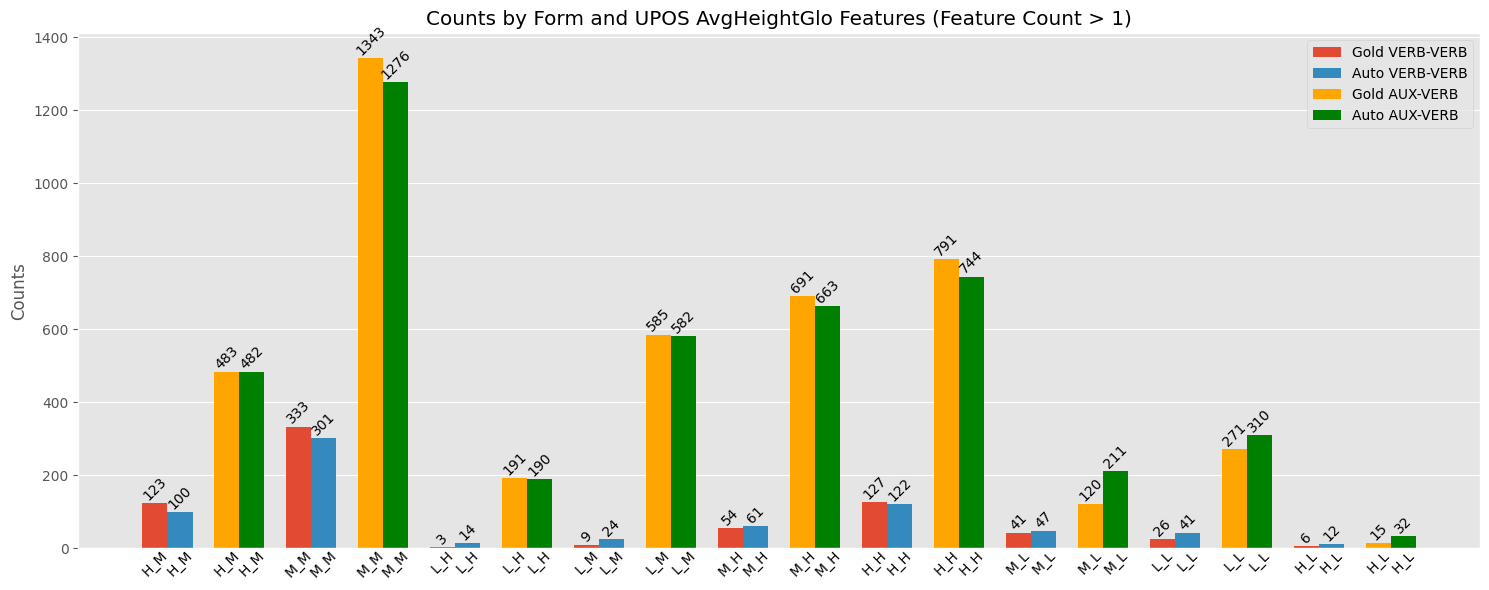

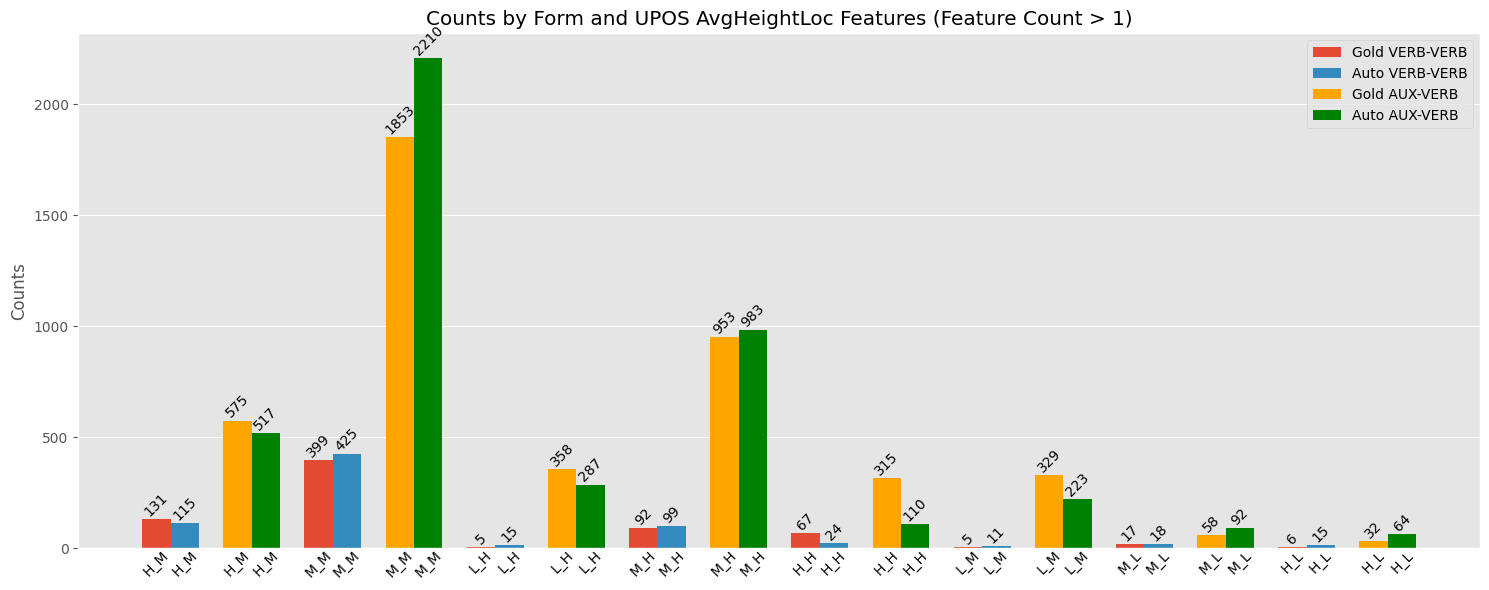

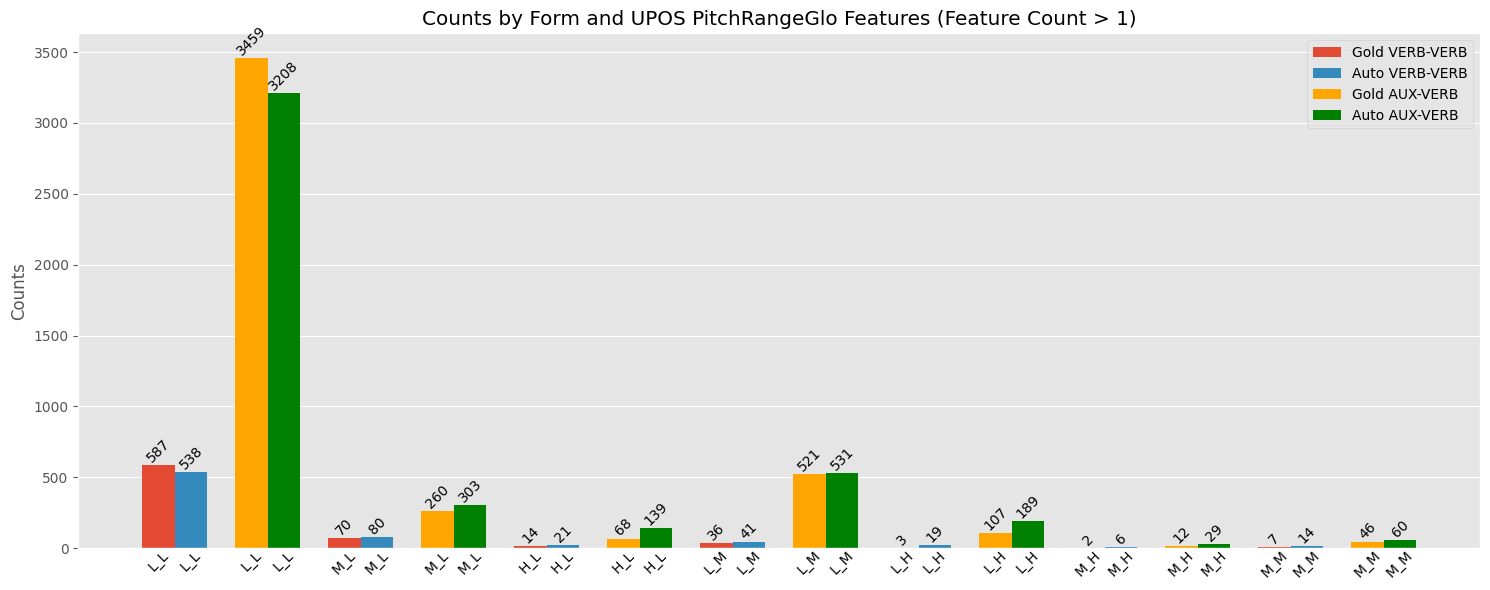

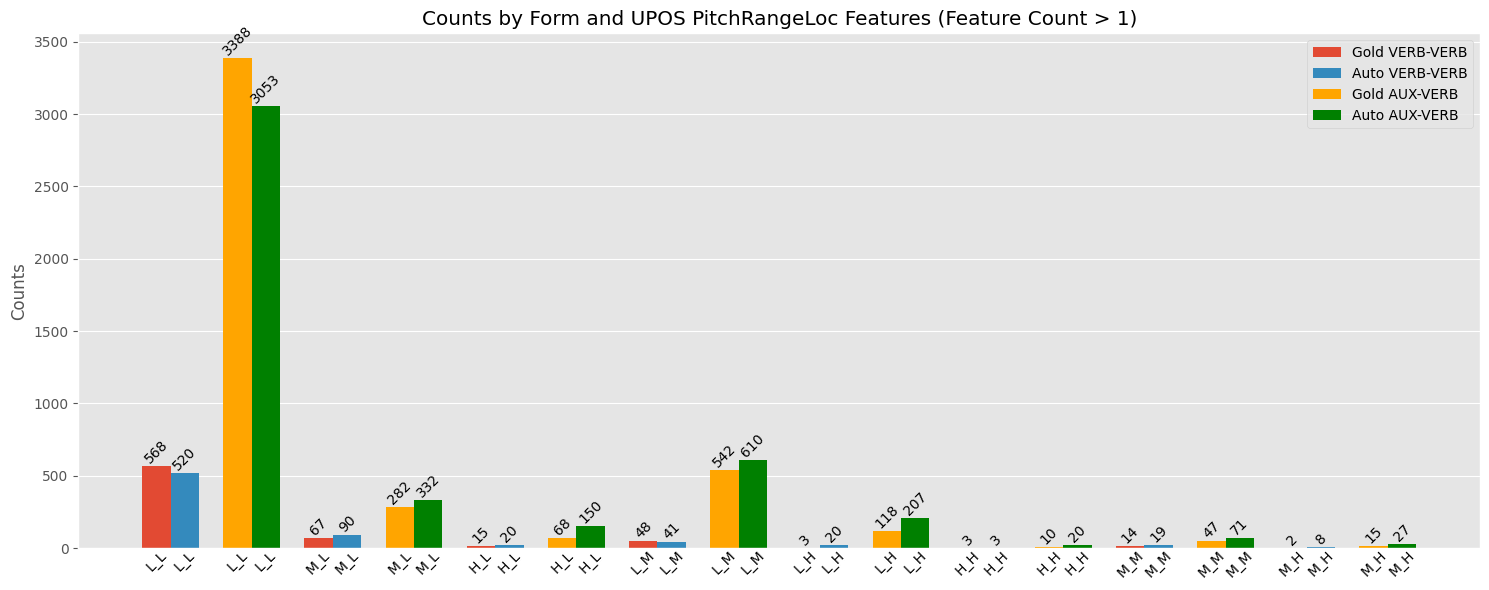

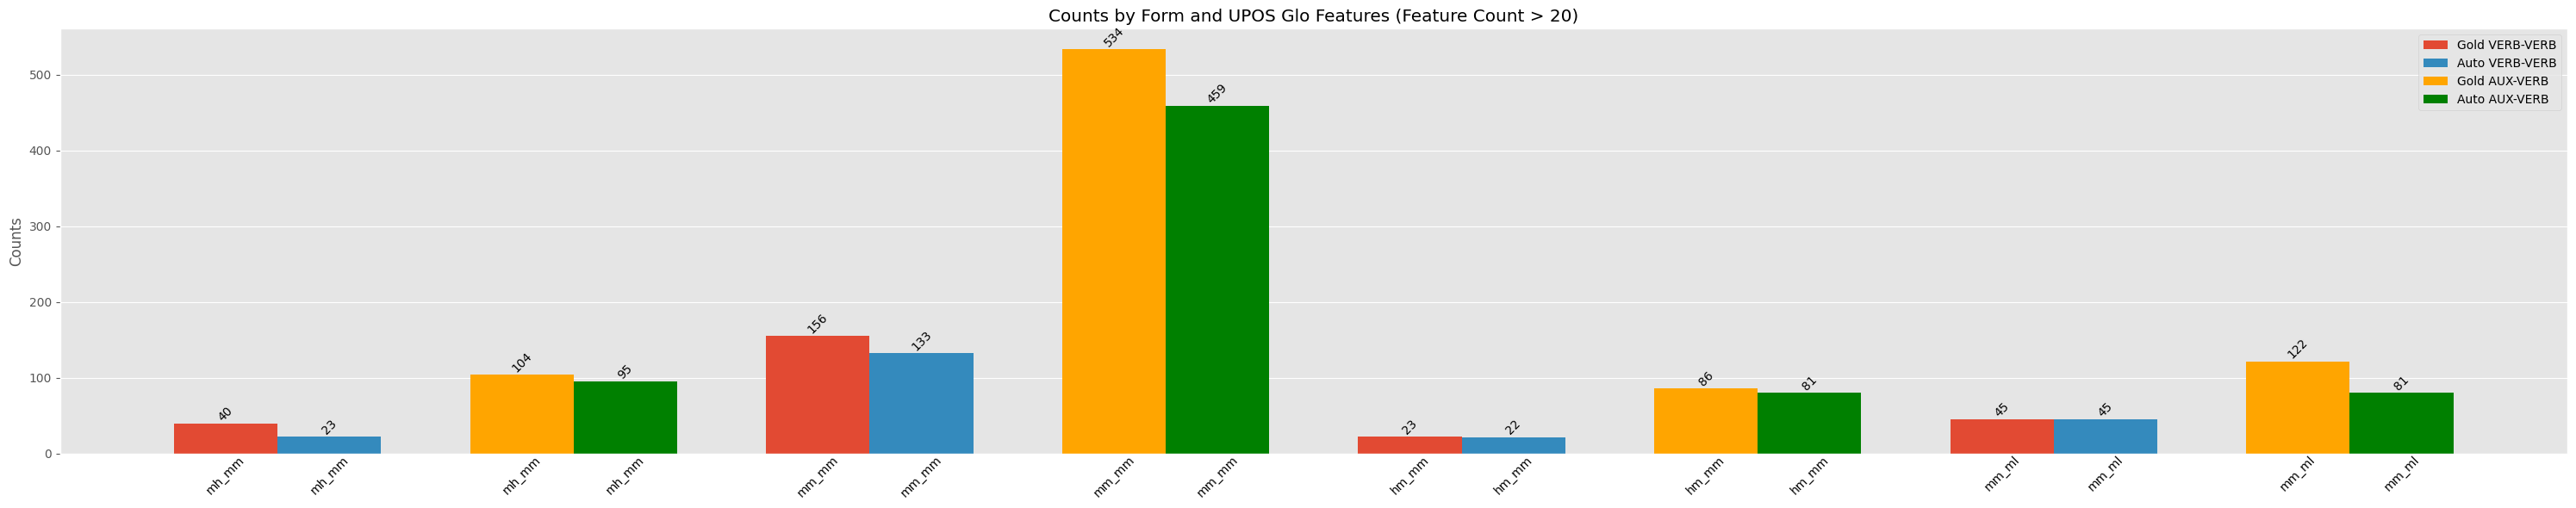

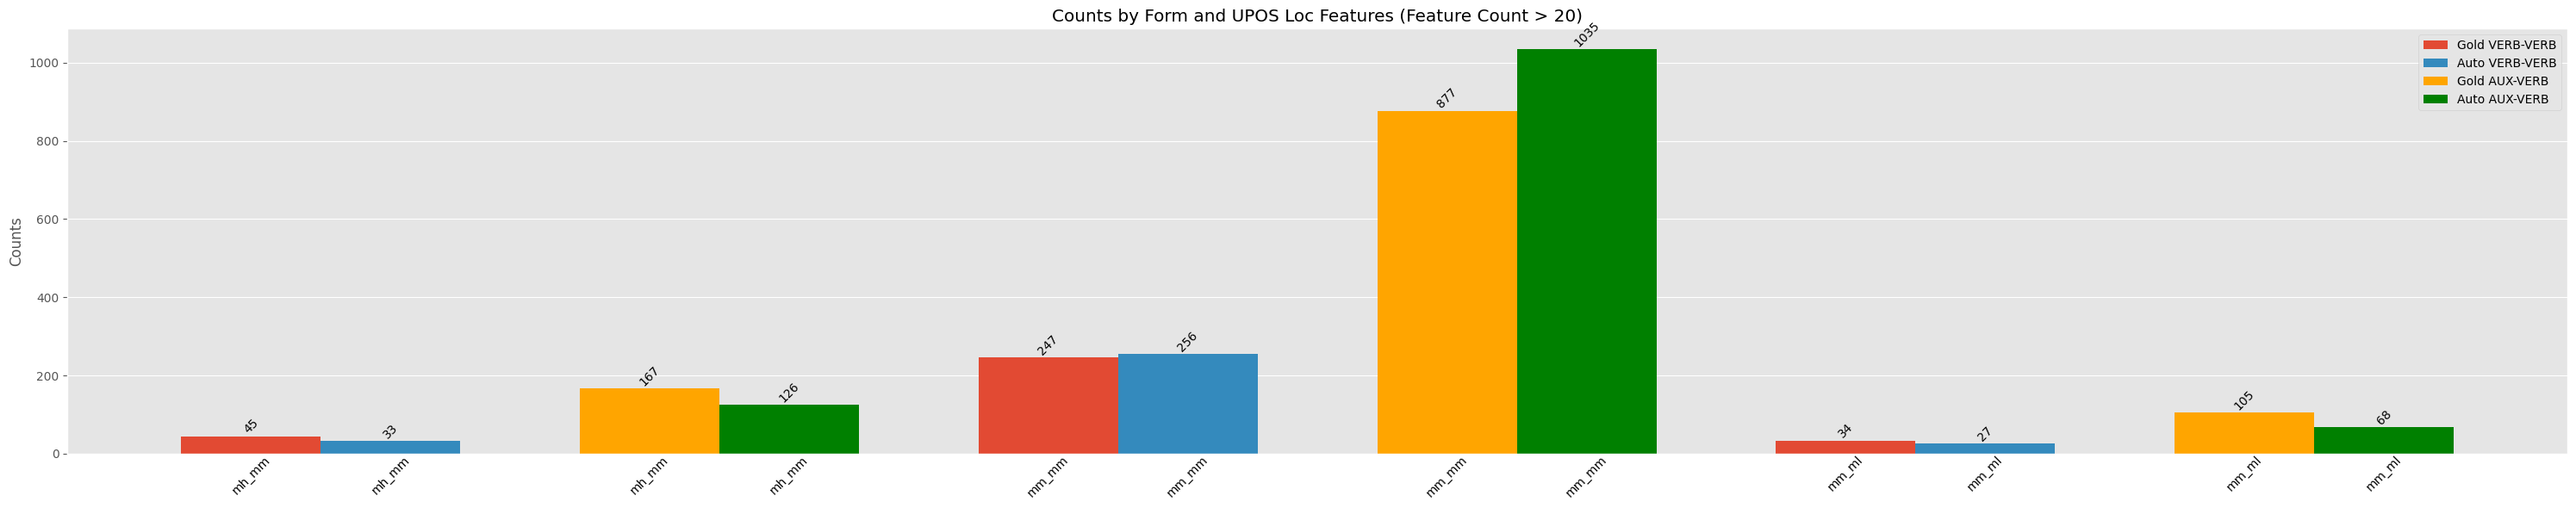

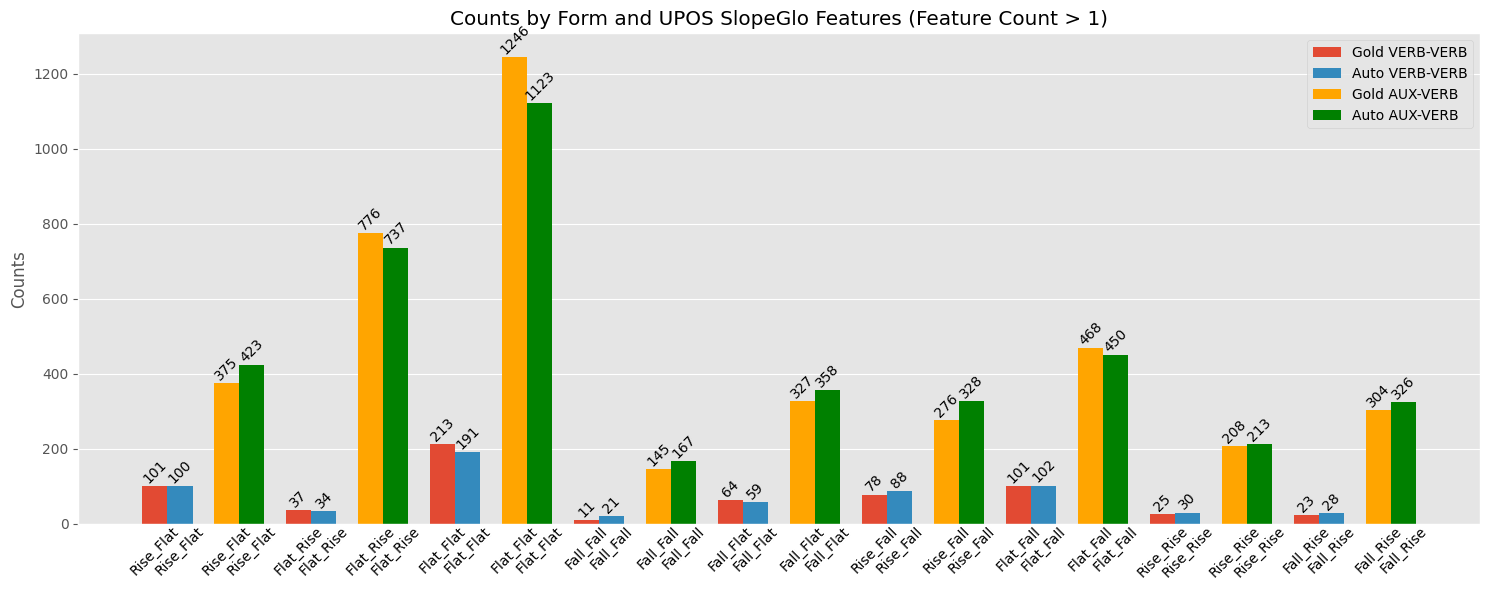

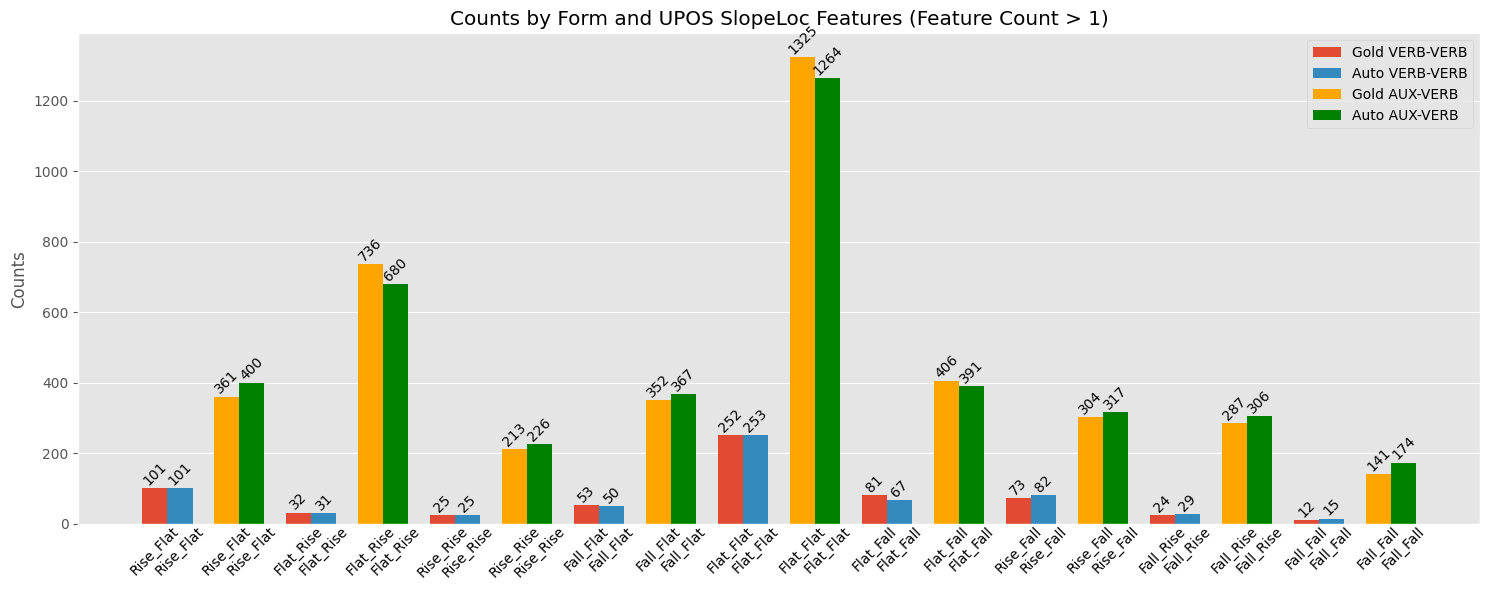

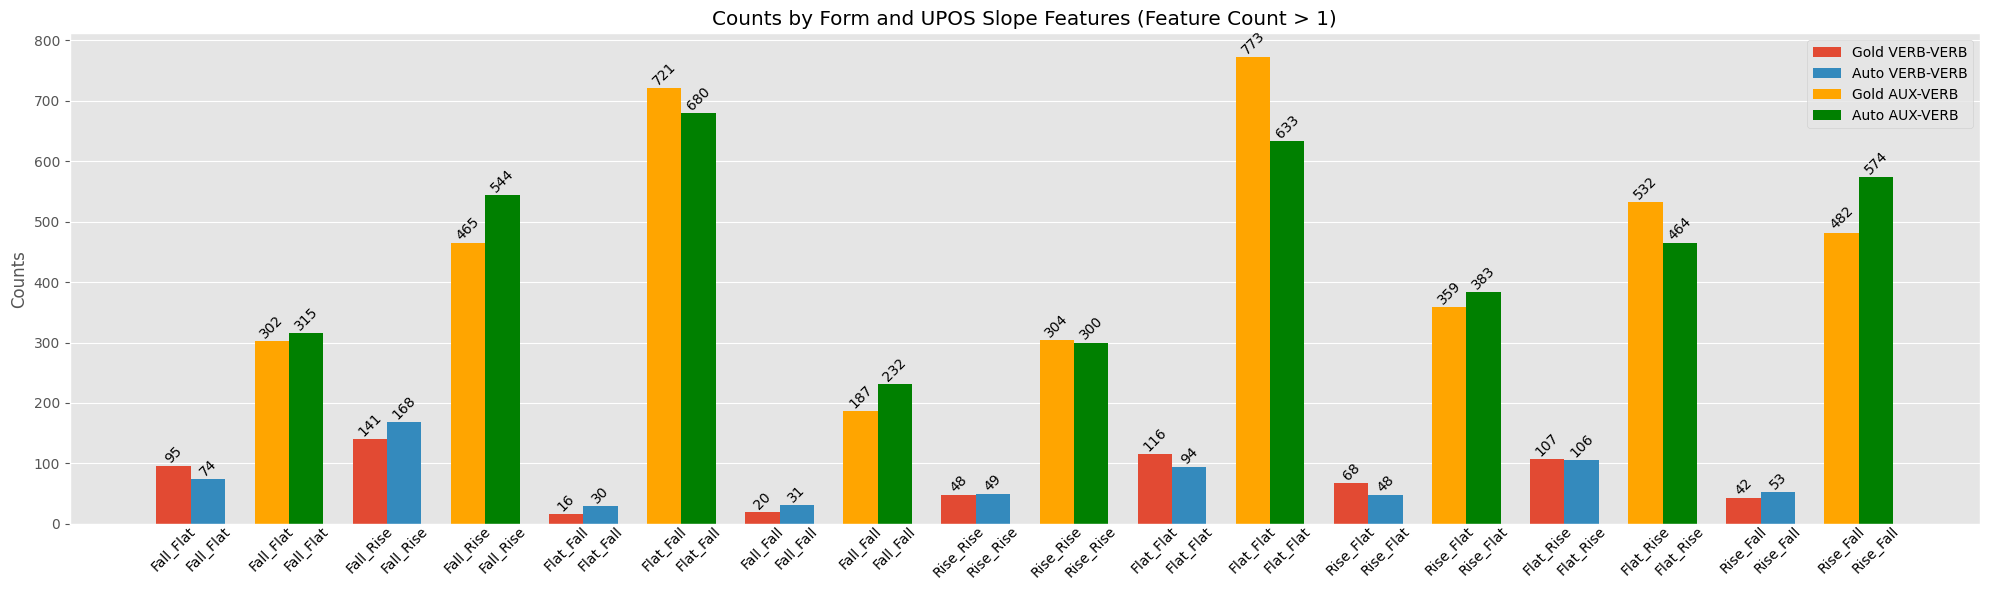

In [14]:
CSV_AUX_VERB = "CSV_AUX_VERB/"
if not os.path.exists(CSV_AUX_VERB):
    os.makedirs(CSV_AUX_VERB)

PNG_AUX_VERB = "PNG_AUX_VERB/"
if not os.path.exists(PNG_AUX_VERB):
    os.makedirs(PNG_AUX_VERB)


def plot_aux_verb(df:pd.DataFrame, feature_name:str, png_outfolder:str, limite:int=100, x_length:int=15) -> None:
    """
    Plots the features for the given dataframe, visually separating VERB and AUX counts.
    
    Parameters:
    df (DataFrame): DataFrame containing the feature counts
    feature_name (str): Name of the feature
    png_outfolder (str): Output folder for the PNG file
    limite (int): Limit for the feature count
    x_length (int): Length of the x-axis

    Returns:
    None
    """
    ax = plt.figure(figsize=(x_length, 6))

    # Keep Count > 150
    if limite:
        df = df[((df['Gold_Count_VERB-VERB'] > limite) & (df['Auto_Count_VERB-VERB'] > limite)) & ((df['Gold_Count_AUX-VERB'] > limite) & (df['Auto_Count_AUX-VERB'] > limite))]

    # Increased bar_width and index adjustment for clear separation
    bar_width = 0.35  # width of bars
    # Double the spacing between the forms to accommodate the second bar for AUX
    index = range(0, len(df) * 2, 2)  # x coordinates for the bars


    # Plot VERB counts
    gold_verb_bars = plt.bar(index, df['Gold_Count_VERB-VERB'], bar_width, label='Gold VERB-VERB')
    auto_verb_bars = plt.bar([p + bar_width for p in index], df['Auto_Count_VERB-VERB'], bar_width, label='Auto VERB-VERB')

    # Plot AUX counts
    offset = 1  # additional offset to separate VERB and AUX bars
    gold_aux_bars = plt.bar([p + offset for p in index], df['Gold_Count_AUX-VERB'], bar_width, label='Gold AUX-VERB', color='orange')
    auto_aux_bars = plt.bar([p + bar_width + offset for p in index], df['Auto_Count_AUX-VERB'], bar_width, label='Auto AUX-VERB', color='green')

    for bars, label in zip([gold_verb_bars, auto_verb_bars, gold_aux_bars, auto_aux_bars], ['Gold VERB-VERB', 'Auto VERB-VERB', 'Gold AUX-VERB', 'Auto AUX-VERB']):
        for bar in bars:
            yval = bar.get_height()
            bar_index = bars.index(bar)
            if bar_index < len(df):
                plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', ha='center', va='bottom', rotation=45)
                plt.text(bar.get_x() + bar.get_width()/2, 0, df['Form'].iloc[bar_index], ha='center', va='top', rotation=45, color='black')

    # plt.xlabel('Forms')
    plt.ylabel('Counts')
    plt.title(f'Counts by Form and UPOS {feature_name} Features (Feature Count > {limite})')
    plt.xticks([])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{png_outfolder}/{feature_name}_features.png')
    plt.show()


def convert_mono_aux_verb_defaultdict_to_df(nested_dict:defaultdict) -> pd.DataFrame:
    """
    Converts the nested defaultdict to a DataFrame for the monosyllabic auxiliary verbs.

    Parameters:
    nested_dict (defaultdict): Nested defaultdict containing the feature counts

    Returns:
    df (DataFrame): DataFrame containing the feature counts
    """
    data = {}
    for (upos1, upos2), forms in nested_dict.items():
        for (form1, form2), counts in forms.items():
            form = form1 + "_" + form2
            if form not in data:
                data[form] = {
                    "Form": form,
                    "Gold_Count_VERB-VERB": 0,
                    "Auto_Count_VERB-VERB": 0,
                    "Gold_Count_AUX-VERB": 0,
                    "Auto_Count_AUX-VERB": 0,
                }
            
            if upos1 == "VERB" and upos2 == "VERB":
                data[form]["Gold_Count_VERB-VERB"] = counts["Gold"]
                data[form]["Auto_Count_VERB-VERB"] = counts["Auto"]

            if upos1 == "AUX" and upos2 == "VERB":
                data[form]["Gold_Count_AUX-VERB"] = counts["Gold"]
                data[form]["Auto_Count_AUX-VERB"] = counts["Auto"]

    return pd.DataFrame(list(data.values()))

def convert_mono_aux_verb_defaultdict_to_df_with_percent(nested_dict:defaultdict, total_counts:tuple) -> pd.DataFrame:
    """
    Converts the nested defaultdict to a DataFrame for the monosyllabic auxiliary verbs with percentage values.

    Parameters:
    nested_dict (defaultdict): Nested defaultdict containing the feature counts
    total_counts (tuple): Total counts for VERB-VERB and AUX-VERB

    Returns:
    df (DataFrame): DataFrame containing the feature counts with percentage values
    """
    data = {}
    vv_gold, vv_auto, av_gold, av_auto = total_counts

    for (upos1, upos2), forms in nested_dict.items():
        for (form1, form2), counts in forms.items():
            form = form1 + "_" + form2
            if form not in data:
                data[form] = {
                    "Form": form,
                    "Gold_Count_VERB-VERB": 0,
                    "Auto_Count_VERB-VERB": 0,
                    "Gold_Count_AUX-VERB": 0,
                    "Auto_Count_AUX-VERB": 0,
                }
            
            if upos1 == "VERB" and upos2 == "VERB":
                gold_count = counts["Gold"]
                auto_count = counts["Auto"]
                gold_percentage = f"{gold_count} ({(gold_count / vv_gold * 100):.2f}%)" if vv_gold > 0 else f"{gold_count} (0.00%)"
                auto_percentage = f"{auto_count} ({(auto_count / vv_auto * 100):.2f}%)" if vv_auto > 0 else f"{auto_count} (0.00%)"
                data[form]["Gold_Count_VERB-VERB"] = gold_percentage
                data[form]["Auto_Count_VERB-VERB"] = auto_percentage

            if upos1 == "AUX" and upos2 == "VERB":
                gold_count = counts["Gold"]
                auto_count = counts["Auto"]
                gold_percentage = f"{gold_count} ({(gold_count / av_gold * 100):.2f}%)" if av_gold > 0 else f"{gold_count} (0.00%)"
                auto_percentage = f"{auto_count} ({(auto_count / av_auto * 100):.2f}%)" if av_auto > 0 else f"{auto_count} (0.00%)"
                data[form]["Gold_Count_AUX-VERB"] = gold_percentage
                data[form]["Auto_Count_AUX-VERB"] = auto_percentage

    return pd.DataFrame(list(data.values()))

def aux_result_aux_verb(gold_files:str, auto_files:str) -> None:
    """
    Computes the results for the monosyllabic verb preceding an auxiliary verb or a verb in gold and auto sentences.

    Parameters:
    gold_files (list): List of gold files
    auto_files (list): List of auto files

    Returns:
    None
    """
    global_avgheightglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_avgheightloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_pitchrangeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_glo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_loc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeglo = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slopeloc = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))
    global_slope = defaultdict(lambda: defaultdict(lambda: {'Gold': 0, 'Auto': 0}))

    total_gold_vv_slam = 0
    total_auto_vv_slam = 0
    total_gold_av_slam = 0
    total_auto_av_slam = 0
    total_gold_vv_slope = 0
    total_auto_vv_slope = 0
    total_gold_av_slope = 0
    total_auto_av_slope = 0
    
    for gold_file in tqdm(gold_files):
        gold_sentences = extract_trees_and_metadata(gold_file)
        basename = os.path.basename(gold_file)
        corresponding_auto_files = [f for f in auto_files if basename in f]

        if corresponding_auto_files:
            auto_file = corresponding_auto_files[0]
            auto_sentences = extract_trees_and_metadata(auto_file)

            if len(gold_sentences) != len(auto_sentences):
                print(f"Gold and Auto sentences mismatch for {gold_file}")
                continue

            avgheightglo_count, avgheightloc_count, pitchrangeglo_count, pitchrangeloc_count, glo_count, loc_count, slam_vv_gold, slam_vv_auto, slam_av_gold, slam_av_auto = SLAM_mono_aux_verb(gold_sentences, auto_sentences)
            slopeglo_count, slopeloc_count, slope_count, slope_vv_gold, slope_vv_auto, slope_av_gold, slope_av_auto = Slope_mono_aux_verb(gold_sentences, auto_sentences)

            for upos, forms in avgheightglo_count.items():
                for form, counts in forms.items():
                    global_avgheightglo[upos][form]['Gold'] += counts['Gold']
                    global_avgheightglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in avgheightloc_count.items():
                for form, counts in forms.items():
                    global_avgheightloc[upos][form]['Gold'] += counts['Gold']
                    global_avgheightloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeglo_count.items():
                for form, counts in forms.items():
                    global_pitchrangeglo[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in pitchrangeloc_count.items():
                for form, counts in forms.items():
                    global_pitchrangeloc[upos][form]['Gold'] += counts['Gold']
                    global_pitchrangeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in glo_count.items():
                for form, counts in forms.items():
                    global_glo[upos][form]['Gold'] += counts['Gold']
                    global_glo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in loc_count.items():
                for form, counts in forms.items():
                    global_loc[upos][form]['Gold'] += counts['Gold']
                    global_loc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeglo_count.items():
                for form, counts in forms.items():
                    global_slopeglo[upos][form]['Gold'] += counts['Gold']
                    global_slopeglo[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slopeloc_count.items():
                for form, counts in forms.items():
                    global_slopeloc[upos][form]['Gold'] += counts['Gold']
                    global_slopeloc[upos][form]['Auto'] += counts['Auto']

            for upos, forms in slope_count.items():
                for form, counts in forms.items():
                    global_slope[upos][form]['Gold'] += counts['Gold']
                    global_slope[upos][form]['Auto'] += counts['Auto']

            
            total_gold_vv_slam += slam_vv_gold
            total_auto_vv_slam += slam_vv_auto
            total_gold_av_slam += slam_av_gold
            total_auto_av_slam += slam_av_auto
            total_gold_vv_slope += slope_vv_gold
            total_auto_vv_slope += slope_vv_auto
            total_gold_av_slope += slope_av_gold
            total_auto_av_slope += slope_av_auto

    slam_total = (total_gold_vv_slam, total_auto_vv_slam, total_gold_av_slam, total_auto_av_slam)
    slope_total = (total_gold_vv_slope, total_auto_vv_slope, total_gold_av_slope, total_auto_av_slope)
    
    global_avgheightglo_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_avgheightglo, slam_total)
    global_avgheightloc_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_avgheightloc, slam_total)
    global_pitchrangeglo_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_pitchrangeglo, slam_total)
    global_pitchrangeloc_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_pitchrangeloc, slam_total)
    global_glo_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_glo, slam_total)
    global_loc_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_loc, slam_total)
    global_slopeglo_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_slopeglo, slope_total)
    global_slopeloc_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_slopeloc, slope_total)
    global_slope_df = convert_mono_aux_verb_defaultdict_to_df_with_percent(global_slope, slope_total)

    global_avgheightglo_df.to_csv(f'{CSV_AUX_VERB}global_avgheightglo_aux-verb_verb.csv', index=False)
    global_avgheightloc_df.to_csv(f'{CSV_AUX_VERB}global_avgheightloc_aux-verb_verb.csv', index=False)
    global_pitchrangeglo_df.to_csv(f'{CSV_AUX_VERB}global_pitchrangeglo_aux-verb_verb.csv', index=False)
    global_pitchrangeloc_df.to_csv(f'{CSV_AUX_VERB}global_pitchrangeloc_aux-verb_verb.csv', index=False)
    global_glo_df.to_csv(f'{CSV_AUX_VERB}global_glo_aux-verb_verb.csv', index=False)
    global_loc_df.to_csv(f'{CSV_AUX_VERB}global_loc_aux-verb_verb.csv', index=False)
    global_slopeglo_df.to_csv(f'{CSV_AUX_VERB}global_slopeglo_aux-verb_verb.csv', index=False)
    global_slopeloc_df.to_csv(f'{CSV_AUX_VERB}global_slopeloc_aux-verb_verb.csv', index=False)
    global_slope_df.to_csv(f'{CSV_AUX_VERB}global_slope_aux-verb_verb.csv', index=False)

    global_avgheightglo_df = convert_mono_aux_verb_defaultdict_to_df(global_avgheightglo)
    global_avgheightloc_df = convert_mono_aux_verb_defaultdict_to_df(global_avgheightloc)
    global_pitchrangeglo_df = convert_mono_aux_verb_defaultdict_to_df(global_pitchrangeglo)
    global_pitchrangeloc_df = convert_mono_aux_verb_defaultdict_to_df(global_pitchrangeloc)
    global_glo_df = convert_mono_aux_verb_defaultdict_to_df(global_glo)
    global_loc_df = convert_mono_aux_verb_defaultdict_to_df(global_loc)
    global_slopeglo_df = convert_mono_aux_verb_defaultdict_to_df(global_slopeglo)
    global_slopeloc_df = convert_mono_aux_verb_defaultdict_to_df(global_slopeloc)
    global_slope_df = convert_mono_aux_verb_defaultdict_to_df(global_slope)

    plot_aux_verb(global_avgheightglo_df, 'AvgHeightGlo', PNG_AUX_VERB, 1)
    plot_aux_verb(global_avgheightloc_df, 'AvgHeightLoc', PNG_AUX_VERB, 1)
    plot_aux_verb(global_pitchrangeglo_df, 'PitchRangeGlo', PNG_AUX_VERB, 1)
    plot_aux_verb(global_pitchrangeloc_df, 'PitchRangeLoc', PNG_AUX_VERB, 1)
    plot_aux_verb(global_glo_df, 'Glo', PNG_AUX_VERB, 20, 30)
    plot_aux_verb(global_loc_df, 'Loc', PNG_AUX_VERB, 20, 30)
    plot_aux_verb(global_slopeglo_df, 'SlopeGlo', PNG_AUX_VERB, 1)
    plot_aux_verb(global_slopeloc_df, 'SlopeLoc', PNG_AUX_VERB, 1)
    plot_aux_verb(global_slope_df, 'Slope', PNG_AUX_VERB, 1, 20)

aux_result_aux_verb(gold_conll_infiles, auto_conll_outfolder)